Machine learning with SFE datasets for HE prediction

In [1]:
#load all packages
import sys
print(sys.executable)
from __future__ import division

import warnings
warnings.filterwarnings('ignore')

import IPython
print("IPython: ",IPython.__version__)

import csv
print("csv: ",csv.__version__)

import pandas as pd
print("pandas: ",pd.__version__)

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib: ",matplotlib.__version__)

import numpy as np
print("numpy: ",np.__version__)

import sklearn
print("Scikit Learn: ",sklearn.__version__)

import tensorflow as tf
print("tensorflow: ",tf.__version__)

import math
import pylab
import time
import pprint as pp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from IPython.display import Image
import shap
print("shap: ",shap.__version__)
import xgboost as xgb
print("xgboost: ",xgb.__version__)

D:\conda_envs\jupyter_env\python.exe
IPython:  9.8.0
csv:  1.0
pandas:  2.1.4
matplotlib:  3.8.0
numpy:  1.26.4
Scikit Learn:  1.3.2

tensorflow:  2.15.0
shap:  0.44.1
xgboost:  2.0.3


Loading dataset using pandas 

In [2]:
#set display options for pandas data framework
pd.options.display.max_columns=50
pd.options.display.max_rows=300

#ini_dataset is the as-is load of the sfe data without any preprocess
ini_dataset=pd.read_csv('Final SFE Data.csv',delimiter=',',index_col=None,header=0)
colheaders=list(ini_dataset.columns.values)

print(colheaders)
print("\n")
print(ini_dataset.head(2))

['C', 'N', 'P', 'S', 'V', 'Ni', 'Nb', 'Al', 'Ti', 'Fe', 'Hf', 'Mo', 'Mn', 'Co', 'Si', 'Cr', 'Cu', 'DOI', 'url', 'SFE', 'Error', 'title', 'Author', 'temperature', 'experiment_type']


       C      N      P      S    V    Ni   Nb   Al   Ti      Fe   Hf   Mo  \
0  0.004  0.003  0.025  0.001  0.0  15.6  0.0  0.0  0.0  64.317  0.0  2.5   
1  0.020  0.009  0.022  0.001  0.0  15.6  0.0  0.0  0.0  64.188  0.0  2.5   

     Mn   Co    Si    Cr   Cu                        DOI  \
0  0.03  0.0  0.02  17.5  0.0  10.1007/s11661-013-1943-0   
1  0.03  0.0  0.03  17.6  0.0  10.1007/s11661-013-1943-0   

                                                 url   SFE     Error  \
0  http://link.springer.com/article/10.1007/s1166...  51.6  0.014341   
1  http://link.springer.com/article/10.1007/s1166...  54.6  0.023810   

                                               title            Author  \
0  The Effect of Chemical Composition and Heat Tr...  Yonezawa, Toshio   
1  The Effect of Chemical Composition a

Dataprocessing

selecting measurements only on room temperature

In [3]:
print("There are total %d observations in the dataset" %len(ini_dataset))
print("There are total %d observations in the dataset that are room temperature measurements" %len(ini_dataset[(ini_dataset.temperature>290)&(ini_dataset.temperature<310)]))
#subset with room temperature measuremnets
ini_dataset_1=ini_dataset[(ini_dataset.temperature>290)&(ini_dataset.temperature<310)]
print("There are total %d observations in the room temp dataset"%len(ini_dataset_1))

There are total 473 observations in the dataset
There are total 426 observations in the dataset that are room temperature measurements
There are total 426 observations in the room temp dataset


selecting measurements from only experiments

In [4]:
#displaying different experiment types in our dataset
print(ini_dataset_1.experiment_type.unique())

['TEM - WBDF' 'XRD' 'TEM' 'Thermodynamic Modeling' 'Synchrotron XRD'
 'TEM-WBDF' 'Neutron Diffraction' 'Literature Review' 'Literature review']


In [5]:
len(ini_dataset_1[ini_dataset_1.experiment_type !='Thermodynamic Modeling'])

387

In [6]:
# ini_dataset_2 is another subset with only experimental values
ini_dataset_2= ini_dataset_1[ini_dataset_1.experiment_type!='Thermodynamic Modeling']
print(len(ini_dataset_2),"\n")

#dropping columns url and doi
print(ini_dataset_2.columns.values)
print(len(ini_dataset_2.columns.values))
print(ini_dataset_2.columns[[17,18]],"\n")
ini_dataset_2=ini_dataset_2.drop(['DOI','url'],axis=1)
print(ini_dataset_2.columns.values)
print(len(ini_dataset_2.columns.values))

387 

['C' 'N' 'P' 'S' 'V' 'Ni' 'Nb' 'Al' 'Ti' 'Fe' 'Hf' 'Mo' 'Mn' 'Co' 'Si'
 'Cr' 'Cu' 'DOI' 'url' 'SFE' 'Error' 'title' 'Author' 'temperature'
 'experiment_type']
25
Index(['DOI', 'url'], dtype='object') 

['C' 'N' 'P' 'S' 'V' 'Ni' 'Nb' 'Al' 'Ti' 'Fe' 'Hf' 'Mo' 'Mn' 'Co' 'Si'
 'Cr' 'Cu' 'SFE' 'Error' 'title' 'Author' 'temperature' 'experiment_type']
23


In [7]:
#ini_dataset_3 is next subset with only ferrous alloys
print(len(ini_dataset_2))
print(len(ini_dataset_2[ini_dataset_2.Author!='Unfried-Silgado, Jimy']))
ini_dataset_3=ini_dataset_2[ini_dataset.Author!='Unfried-Silgado, Jimy']
print(len(ini_dataset_3))

387
379
379


selecting predictor variables

In [8]:
colheaders_2=['C','N','P','S','V','Ni','Nb','Mn','Al','Ti','Fe','Hf','Mo','Co','Si','Cr','Cu']
for item in colheaders_2:
    print (item,len(ini_dataset_3[ini_dataset_3[item]>0]),len(ini_dataset_3[ini_dataset_3[item]>0.05]))

C 339 98
N 248 85
P 170 7
S 170 1
V 0 0
Ni 300 300
Nb 2 2
Mn 305 217
Al 34 27
Ti 0 0
Fe 379 379
Hf 0 0
Mo 168 133
Co 3 3
Si 240 120
Cr 332 332
Cu 6 6


In [9]:
#check measurements with (Nb, Co, Cu)
ini_dataset_3_1=ini_dataset_3[(ini_dataset_3.Nb>0.05)|(ini_dataset_3.Co>0.05)|(ini_dataset_3.Cu>0.05)]
ini_dataset_3_1.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,]]

,C,N,P,S,V,Ni,Nb,Al,Ti,Fe,Hf,Mo,Mn,Co,Si,Cr,Cu,SFE,Error,Author
117,0.047,0.205,0.00,0.000,0.0,3.71,0.00,0.0,0.0,71.218,0.0,0.05,6.74,0.00,0.32,17.48,0.23,13.20,0.000000,"Barman, H."
132,0.047,0.205,0.00,0.000,0.0,3.71,0.00,0.0,0.0,71.218,0.0,0.05,6.74,0.00,0.32,17.48,0.23,15.84,0.000000,"Barman, H."
237,0.041,0.054,0.00,0.000,0.0,8.10,0.00,0.0,0.0,70.875,0.0,0.32,1.71,0.00,0.33,18.20,0.37,17.80,0.067416,"Talonen, J."
238,0.019,0.094,0.00,0.000,0.0,6.60,0.00,0.0,0.0,73.237,0.0,0.14,1.61,0.00,0.48,17.60,0.22,12.80,0.117188,"Talonen, J."
239,0.017,0.145,0.00,0.000,0.0,6.60,0.00,0.0,0.0,73.698,0.0,0.15,1.34,0.00,0.51,17.40,0.14,14.70,0.054422,"Talonen, J."
256,0.023,0.000,0.00,0.000,0.0,8.59,0.00,0.0,0.0,66.667,0.0,0.00,0.15,6.42,0.19,17.96,0.00,11.50,0.000000,"Dulieu, D."
257,0.115,0.000,0.00,0.000,0.0,10.04,0.00,0.0,0.0,66.525,0.0,0.00,0.22,0.00,0.10,17.80,5.20,63.25,0.090900,"Dulieu, D."
335,0.006,0.007,0.01,0.014,0.0,15.00,0.00,0.0,0.0,49.420,0.0,0.00,0.04,20.20,0.00,15.30,0.00,27.60,0.000000,"Silcock, J.M."
339,0.000,0.000,0.00,0.000,0.0,10.10,0.00,0.0,0.0,64.350,0.0,0.00,0.00,9.55,0.00,16.00,0.00,18.40,0.000000,"Silcock, J.M."
351,0.014,0.004,0.00,0.000,0.0,20.00,1.00,0.0,0.0,58.982,0.0,0.00,0.00,0.00,0.00,20.00,0.00,17.25,0.000000,"Douglass, D.L."


In [10]:
#ini_dataset_4 is the next subset with the chosen 9 elements with enough datapoints
ini_dataset_4=ini_dataset_3[(ini_dataset_3.Nb<1)&(ini_dataset_3.Co<1)&(ini_dataset_3.Cu<1)]
len(ini_dataset_4)

374

In [11]:
ini_dataset_4=ini_dataset_4.drop(['P','S','V','Nb','Co','Ti','Hf','Cu'],axis=1)
print(ini_dataset_4.columns.values)
print(len(ini_dataset_4.columns.values))


['C' 'N' 'Ni' 'Al' 'Fe' 'Mo' 'Mn' 'Si' 'Cr' 'SFE' 'Error' 'title' 'Author'
 'temperature' 'experiment_type']
15


In [12]:
index=range(1,len(ini_dataset_4)+1)
#ini_dataset_5 is another dataframe to make some format changes and let ini_dataset_4 ba as-is
ini_dataset_5=ini_dataset_4
print(len(ini_dataset_5))
ini_dataset_5.insert(0,'sno',index)

374


In [13]:
ini_dataset_5=ini_dataset_5.set_index(['sno'])
#display the final data framework
ini_dataset_5.head()

,C,N,Ni,Al,Fe,Mo,Mn,Si,Cr,SFE,Error,title,Author,temperature,experiment_type
sno,,,,,,,,,,,,,,,
1,0.004,0.003,15.6,0.0,64.317,2.5,0.03,0.02,17.5,51.6,0.014341,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
2,0.020,0.009,15.6,0.0,64.188,2.5,0.03,0.03,17.6,54.6,0.023810,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
3,0.020,0.002,14.0,0.0,66.409,2.4,0.03,0.01,17.1,50.3,0.023062,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
4,0.005,0.001,15.6,0.0,63.866,2.6,0.19,0.01,17.7,52.8,0.012879,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
5,0.016,0.008,10.8,0.0,68.899,0.3,0.85,0.10,19.0,35.0,0.023429,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF


convert data framework to arrays

In [14]:
ini_array=ini_dataset_5.reset_index().values
print(ini_array.shape)
print(ini_array[0,:])

(374, 16)
[1 0.004 0.003 15.6 0.0 64.317 2.5 0.03 0.02 17.5 51.6 0.014341085
 'The Effect of Chemical Composition and Heat Treatment Conditions on Stacking Fault Energy for Fe-Cr-Ni Austenitic Stainless Steel'
 'Yonezawa, Toshio' 300 'TEM - WBDF']


In [15]:
#subsetting the array to include only numerical values needed for analysis
SFEdata=ini_array[:,0:12]
print(SFEdata[0,:])
SFEdata=np.array(SFEdata, dtype='float')

#constructing a band of SFE values based on error bars (SFE low and SFE high)
low=SFEdata[:,10]*(1-SFEdata[:,11])
high=SFEdata[:,10]*(1+SFEdata[:,11])
lowhigh=np.column_stack((low,high))

#adding the SFE band columns to the array
SFEdata=np.column_stack((SFEdata,lowhigh))
print(SFEdata.shape)
print(SFEdata[0,:])

[1 0.004 0.003 15.6 0.0 64.317 2.5 0.03 0.02 17.5 51.6 0.014341085]
(374, 14)
[1.0000000e+00 4.0000000e-03 3.0000000e-03 1.5600000e+01 0.0000000e+00
 6.4317000e+01 2.5000000e+00 3.0000000e-02 2.0000000e-02 1.7500000e+01
 5.1600000e+01 1.4341085e-02 5.0860000e+01 5.2340000e+01]


create SFE classes

In [16]:
#determine class based on sfe values
SFEclass=np.zeros(SFEdata.shape[0])
SFEclass[SFEdata[:,10]<=20]=1
SFEclass[(SFEdata[:,10]>20)&(SFEdata[:,10]<=40)]=2
SFEclass[(SFEdata[:,10]>40)]=3

#check number of entries for each class
print((SFEclass==1).sum())
print((SFEclass==2).sum())
print((SFEclass==3).sum())

#check if only the needed classes there
print((SFEclass==1).sum()+(SFEclass==2).sum()+(SFEclass==3).sum())
print(SFEclass.shape)
print(SFEdata.shape)

77
143
154
374
(374,)
(374, 14)


Data analysis(SHAP value and permutation importance)

In [17]:
print(SFEclass[[35,54,57,88,246,283]])

[1. 1. 3. 3. 3. 3.]


In [18]:
#data preprocessing
Elements=SFEdata[:,1:10]
print(Elements.shape)
print('Elementlist:',ini_dataset_5.columns.values[0:9])
def arraynorm(array, axis):
    minaxis=np.nanmin(array,axis)
    maxaxis=np.nanmax(array,axis)
    diffaxis=maxaxis-minaxis
    output=np.true_divide(array-minaxis,diffaxis)
    return output
def arraystandardize(array,axis):
    meanaxis=np.mean(array,axis)
    stdaxis=np.std(array,axis)
    output=np.true_divide(array-meanaxis,stdaxis)
    return output
NormElements=arraynorm(Elements[:,:],0) #Perform normalization on element data
print(NormElements.shape)
StdElements=arraystandardize(Elements[:,:],0)#Standardize element data
SFEclassint=np.array(SFEclass,dtype='int')#Convert SFE category to integer type

(374, 9)
Elementlist: ['C' 'N' 'Ni' 'Al' 'Fe' 'Mo' 'Mn' 'Si' 'Cr']
(374, 9)


classification

In [19]:
#80:20::train:test sets
#Build models on the training set, evaluate performance on unseen test sets, and select the model with the best generalization ability

In [20]:
from sklearn.model_selection import (train_test_split, StratifiedKFold, RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,precision_recall_fscore_support)
from imblearn.over_sampling import SMOTE  # 处理数据不平衡
from imblearn.pipeline import Pipeline as ImbPipeline  # 兼容SMOTE的Pipeline
import warnings
from sklearn.utils.validation import check_X_y, check_array
warnings.filterwarnings('ignore')  # 屏蔽无关警告

# First check the data distribution (key!)
def check_data_distribution(y):
    dist = pd.Series(y).value_counts(normalize=True) * 100
    print("=== Category distribution ===")
    print(dist)
    return dist

# Check data distribution (must be done first!)
check_data_distribution(SFEclass)

print("=== Split the training+validation set&independent testing set ===")
# Maintain category distribution (strategize) during splitting, fix random seeds to ensure reproducibility
X_train_val,X_test,y_train_val,y_test=train_test_split(NormElements,SFEclass,test_size=0.2,stratify=SFEclass,random_state=42)
print("first step:divide independent train set")
print(f"train+validation set:{X_train_val.shape[0]}sample")
print(f"independent test set:{X_test.shape[0]}sample")
print("-"*50)

# Standardization: Fit only on the training and validation set to avoid data leakage
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
# ===================== 3. Handling data imbalance (SMOTE oversampling) =====================
print("\n=== Handling Data Imbalance (SMOTE) ===")
smote = SMOTE(random_state=42, k_neighbors=5)  # k_neighbors adjusted based on sample size
X_train_val_smote_svm, y_train_val_smote_svm = smote.fit_resample(X_train_val_scaled, y_train_val)
print(f"SMOTE training set sample size: {X_train_val_smote_svm.shape[0]} (Original: {X_train_val.shape[0]})")
check_data_distribution(y_train_val_smote_svm)

=== Category distribution ===
3.0    41.176471
2.0    38.235294
1.0    20.588235
Name: proportion, dtype: float64
=== Split the training+validation set&independent testing set ===
first step:divide independent train set
train+validation set:299sample
independent test set:75sample
--------------------------------------------------

=== Handling Data Imbalance (SMOTE) ===
SMOTE training set sample size: 369 (Original: 299)
=== Category distribution ===
3.0    33.333333
2.0    33.333333
1.0    33.333333
Name: proportion, dtype: float64


3.0    33.333333
2.0    33.333333
1.0    33.333333
Name: proportion, dtype: float64

Support vector machine

In [21]:
# ===================== SVM hyperparameter optimization (enhanced regularization) =====================
print("\n=== SVM hyperparameter optimization (enhanced regularization) ===")
# Build a Pipeline with SMOTE (to avoid oversampling leakage
svm_pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()), 
    ("svc", SVC(random_state=42, probability=True)),
])

# Hyperparameter space: Enhanced regularization (expanding the search range of C and increasing penalties)
param_dist_svm = {
    "svc__C": np.logspace(-4, 3, 15, base=2),  # Expand the scope of C and enhance regularization
    "svc__gamma": np.logspace(-10, 0, 8, base=2),  # Refine gamma search
    "svc__kernel": ["rbf", "linear"],  # Prioritize kernel functions with better robustness
    "svc__class_weight": ["balanced"],  # Mandatory category weight balance
    "svc__max_iter": [10000]  # Increase the number of iterations to ensure convergence
}

# Layered 5-fold cross validation (improves stability)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random search (efficiently finding the optimal parameters)
random_search_svm = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=param_dist_svm,
    n_iter=80,  # Increase search frequency to find better parameters
    cv=skf,
    scoring="accuracy",
    n_jobs=1,
    verbose=1,
    random_state=42
)

# train
random_search_svm.fit(X_train_val_scaled, y_train_val)
best_params=random_search_svm.best_params_
# Output the optimal result
print(f"\nSVM Optimal hyperparameters: {best_params}")
print(f"SVM Cross validation for optimal accuracy: {random_search_svm.best_score_:.4f}")
print(f"SVM Cross validation accuracy (mean ± standard deviation): {random_search_svm.cv_results_['mean_test_score'].mean():.4f} ± {random_search_svm.cv_results_['mean_test_score'].std():.4f}")
print(f"Cross validation accuracy (per fold): {random_search_svm.cv_results_['mean_test_score']}")


=== SVM hyperparameter optimization (enhanced regularization) ===
Fitting 5 folds for each of 80 candidates, totalling 400 fits

SVM Optimal hyperparameters: {'svc__max_iter': 10000, 'svc__kernel': 'rbf', 'svc__gamma': 0.1380111892092266, 'svc__class_weight': 'balanced', 'svc__C': 2.8284271247461903}
SVM Cross validation for optimal accuracy: 0.7124
SVM Cross validation accuracy (mean ± standard deviation): 0.6553 ± 0.0377
Cross validation accuracy (per fold): [0.61214689 0.61225989 0.66225989 0.66892655 0.63875706 0.69576271
 0.68220339 0.62214689 0.65559322 0.68231638 0.65892655 0.69915254
 0.55887006 0.68548023 0.66559322 0.69887006 0.68564972 0.65559322
 0.6820904  0.66559322 0.66559322 0.65892655 0.68220339 0.62519774
 0.59898305 0.66214689 0.59853107 0.68564972 0.68220339 0.68231638
 0.57864407 0.66553672 0.65892655 0.65548023 0.5819209  0.66892655
 0.61231638 0.65892655 0.66892655 0.68231638 0.68220339 0.57864407
 0.68898305 0.57864407 0.69570621 0.5819209  0.68231638 0.5989265

In [22]:
# ===================== Training the final SVM model&comprehensive evaluation =====================
print("\n=== Training the final SVM model&comprehensive evaluation ===")
# optimal model
best_svm = SVC(C=random_search_svm.best_params_["svc__C"],
gamma=random_search_svm.best_params_["svc__gamma"],
kernel=random_search_svm.best_params_["svc__kernel"],
class_weight=random_search_svm.best_params_["svc__class_weight"],
max_iter=10000,random_state=42,probability=True)

# Train with SMOTE data
best_svm.fit(X_train_val_smote_svm, y_train_val_smote_svm)

# prediction
y_train_pred_svm = best_svm.predict(X_train_val_scaled)
y_test_pred_svm = best_svm.predict(X_test_scaled)

# accuracy
train_acc_svm = accuracy_score(y_train_val, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)
print(f"\nSVM Training set accuracy: {train_acc_svm:.4f}")
print(f"SVM Test set accuracy: {test_acc_svm:.4f}")

# Detailed evaluation (accuracy, recall, F1)
print("\n=== SVM Test Set Detailed Evaluation Report ===")
print(classification_report(y_test, y_test_pred_svm))

# 混淆矩阵
cm = confusion_matrix(y_test, y_test_pred_svm)
print("\n=== confusion matrix ===")
print(cm)


=== Training the final SVM model&comprehensive evaluation ===

SVM Training set accuracy: 0.7926
SVM Test set accuracy: 0.6267

=== SVM Test Set Detailed Evaluation Report ===
              precision    recall  f1-score   support

         1.0       0.69      0.73      0.71        15
         2.0       0.52      0.41      0.46        29
         3.0       0.67      0.77      0.72        31

    accuracy                           0.63        75
   macro avg       0.63      0.64      0.63        75
weighted avg       0.61      0.63      0.62        75


=== confusion matrix ===
[[11  4  0]
 [ 5 12 12]
 [ 0  7 24]]


In [23]:
#output various metrics
from sklearn.metrics import confusion_matrix
cm_svc=confusion_matrix(y_test, y_test_pred_svm)
print("Confusion Matrix\n",confusion_matrix(y_test,y_test_pred_svm),"\n")

from sklearn.metrics import precision_score
print("precision scores across classes:",precision_score(y_test,y_test_pred_svm,average=None),"\n")
from sklearn.metrics import recall_score
print("recall scores across classes:",recall_score(y_test,y_test_pred_svm,average=None),"\n")
print("macro precision scores:",precision_score(y_test,y_test_pred_svm,average='macro'),"\n")
print("macro recall scores:",recall_score(y_test,y_test_pred_svm,average='macro'),"\n")


Confusion Matrix
 [[11  4  0]
 [ 5 12 12]
 [ 0  7 24]] 

precision scores across classes: [0.6875     0.52173913 0.66666667] 

recall scores across classes: [0.73333333 0.4137931  0.77419355] 

macro precision scores: 0.6253019323671497 

macro recall scores: 0.6404399950562353 



In [24]:
#getting percentage values for confusion matrix
np.true_divide(cm_svc,75)*100

array([[14.66666667,  5.33333333,  0.        ],
       [ 6.66666667, 16.        , 16.        ],
       [ 0.        ,  9.33333333, 32.        ]])

<function matplotlib.pyplot.show(close=None, block=None)>

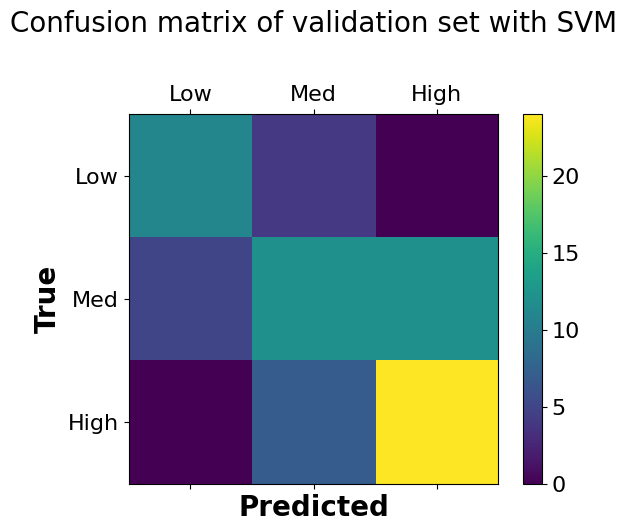

In [25]:
labels=['Low','Med','High']
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(cm_svc,cmap=plt.get_cmap('viridis'))
ax.set_title('Confusion matrix of validation set with SVM',fontsize=20,x=0.5,y=1.2)
cbar=fig.colorbar(cax)
cbar.ax.tick_params(labelsize=16)
ax.set_xticklabels(['']+labels,fontsize=16)
ax.set_yticklabels(['']+labels,fontsize=16)
plt.xlabel('Predicted',fontsize=20,fontweight='bold')
plt.ylabel('True',fontsize=20,fontweight='bold')
plt.savefig("CM_SVC.tiff",format='tiff',dpi=600,bbox_inches='tight',orientation='landscape')
plt.show

Probabilistic calbration curve

In [26]:
from sklearn.calibration import CalibrationDisplay,calibration_curve
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize
#SVM Probability curve analysis
def analyze_calibration_curves(prob_true_list,prob_pred_list,class_names):
    """
    Comprehensive analysis calibration curve
    """
    print("=== Probability calibration curve analysis===\n")
    for i, (prob_true,prob_pred) in enumerate(zip(prob_true_list,prob_pred_list)):
        print(f"---{class_names[i]} analysis---")
        #1.Overall deviation degree
        mean_deviation=np.mean(np.abs(prob_true-prob_pred))
        print(f"Mean absolute variance：{mean_deviation:.4f}")
        #2.Systematic Deviation Analysis
        above_diagonal=np.sum(prob_true>prob_pred)#Actual>Prediction
        below_diagonal=np.sum(prob_true<prob_pred)#Actual<Predicted
        print(f"Points higher than the diagonal：{above_diagonal}/10")
        print(f"Points below the diagonal：{below_diagonal}/10")
        #Calibration quality assessment
        if mean_deviation<0.05:
            calibration_status="Excellent calibration"
        elif mean_deviation<0.1:
            calibration_status="Good calibration"
        elif mean_deviation<0.15:
            calibration_status="General calibration"
        else:
            calibration_status="Poor calibration"
        print(f"Calibration quality：{calibration_status}")
        print()
#Specific pattern recognition
def identify_calibration_patterns(prob_true,prob_pred,class_name):
    """
    Identify specific calibration problem patterns
    """
    print(f"【{class_name}Pattern Analysis】")
    #Calculate slope (using linear regression)
    slope,intercept=np.polyfit(prob_pred,prob_true,1)
    #Pattern Judgment
    if slope>1.2:
        print("Pattern: Overconfidence - Model too deterministic定")
        print("- High probability overestimated, low probability underestimated")
        print("- Suggestion: Increase regularization intensity or use temperature scaling")
    elif slope<0.8:
        print("Pattern: Lack of confidence - Model too conservative")
        print("- Probability prediction is too concentrated around 0.5")
        print("- Suggestion: Adjust the classification threshold or use Platt scaling")
    elif intercept>0.1:
        print("Pattern: Systematic Overestimation")
        print("- The overall prediction probability is relatively high")
        print("- Suggestion: Check for category imbalance issues")
    elif intercept<-0.1:
        print("Pattern: Systematic underestimation")
        print("- The overall prediction probability is low")
        print("- Suggestion: Recalibrate the probability output")
    else:
        print("Mode: Good Calibration")
        print("- The predicted probability is basically consistent with the actual probability")
    print(f"    regression slope：{slope:3f},intercept：{intercept:.3f}\n")
#Quantitative evaluation indicators
from sklearn.metrics import brier_score_loss
def quantitative_calibration_analysis(y_true_bin,y_prob,class_names):
    """
    Quantitative calibration analysis
    """
    print("=== Quantitative evaluation indicators ===\n")
    metrics_results=[]
    for i in range(len(class_names)):
        y_true_class=y_true_bin[:,i]
        y_prob_class=y_prob[:,i]
        #1.Brier Score
        brier_score=brier_score_loss(y_true_class,y_prob_class)
        #2.Reliability diagram area
        prob_true,prob_pred=calibration_curve(y_true_class,y_prob_class,n_bins=10)
        calibration_area=np.trapz(prob_true,prob_pred)
        perfect_area=0.5#Diagonal area below
        #ECE（Expected Calibration Error）
        bin_boundaries=np.linspace(0,1,11)
        bin_indices=np.digitize(y_prob_class,bin_boundaries)-1
        ece=0.0
        for bin_idx in range(10):
            mask=bin_indices==bin_idx
            if np.sum(mask)>0:
                bin_prob_true=np.mean(y_true_class[mask])
                bin_prob_pred=np.mean(y_prob_class[mask])
                bin_weight=np.sum(mask)/len(y_prob_class)
                ece+=bin_weight*np.abs(bin_prob_true-bin_prob_pred)
        metrics_results.append({'class':class_names[i],'brier_score':brier_score,'ece':ece,'calibration_ratio':calibration_area/perfect_area})
        print(f"{class_names[i]}:")
        print(f" Brier Score:{brier_score:.4f}(The smaller, the better.)")
        print(f" ECE:{ece:.4f}(The smaller, the better.)")
        print(f" Calibration area ratio：{calibration_area/perfect_area:.3f}(The closer it is to 1, the better)")
        print()
    return metrics_results

In [27]:
def detailed_calibration_visualization_SVM(y_true_bin,y_prob,class_names):
    """
    Detailed calibration visualization analysis
    """
    fig, axes=plt.subplots(1,3,figsize=(15,5))
    axes=axes.ravel()
    fig.suptitle('Probabilistic calibration curve with SVM',fontsize=20,y=0.98)
    class_names=['Low SFE','Medium SFE','High SFE']
    for i in range(3):
        #Obtain the true label and predicted probability of the current category
        y_true_class=y_true_bin[:,i]
        y_prob_class=y_prob[:,i]
        prob_true,prob_pred=calibration_curve(y_true_class,y_prob_class,n_bins=10,strategy='quantile')
        #plot a curve
       
        axes[i].plot(prob_pred,prob_true,'o-',label=class_names[i],markersize=6,linewidth=2)
       
        axes[i].plot([0,1],[0,1],'k--',label='Ideal calibration',linewidth=1.5)
        
        axes[i].set_xlabel('Mean Predicted Probability',fontsize=11)
        
        axes[i].set_ylabel('Fraction of Positives',fontsize=11)
       
        axes[i].set_title(f'Calibration Curve - {class_names[i]}')
        
        axes[i].legend(loc='best',fontsize=10)
        
        axes[i].grid(True,alpha=0.3)
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.savefig("Probabilistic calbration curve_SVM.tiff",format='tiff',dpi=600,bbox_inches='tight')
    plt.show()

category1(Low SFE) - collected10points
category2(Medium SFE) - collected10points
category3(High SFE) - collected10points
=== Probability calibration curve analysis===

---Low SFE analysis---
Mean absolute variance：0.0603
Points higher than the diagonal：1/10
Points below the diagonal：9/10
Calibration quality：Good calibration

---Medium SFE analysis---
Mean absolute variance：0.1649
Points higher than the diagonal：6/10
Points below the diagonal：4/10
Calibration quality：Poor calibration

---High SFE analysis---
Mean absolute variance：0.1077
Points higher than the diagonal：5/10
Points below the diagonal：5/10
Calibration quality：General calibration

【Low SFEPattern Analysis】
Mode: Good Calibration
- The predicted probability is basically consistent with the actual probability
    regression slope：0.877591,intercept：-0.004

【Medium SFEPattern Analysis】
Pattern: Lack of confidence - Model too conservative
- Probability prediction is too concentrated around 0.5
- Suggestion: Adjust the classifi

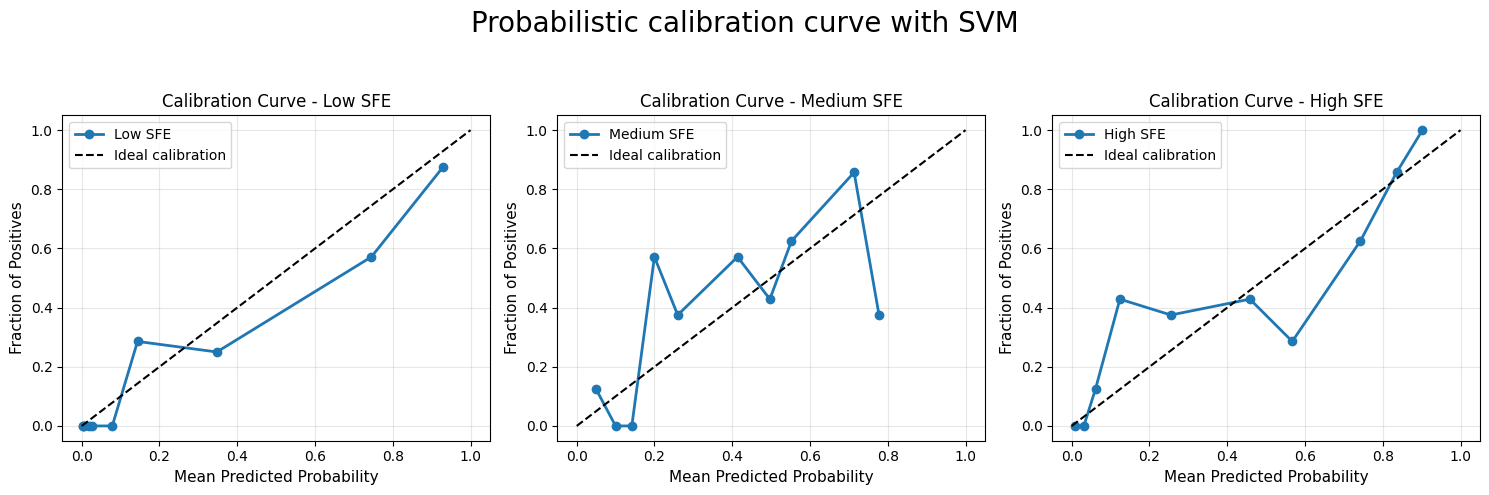

In [28]:
#Convert multi classification to binary format
y_test_bin_svm=label_binarize(y_test,classes=[1,2,3])
#Obtain the probability prediction of the test set
prob_predictions_svm=best_svm.predict_proba(X_test_scaled)
class_names=['Low SFE','Medium SFE','High SFE']
#Collect calibration curve data
prob_true_list_svm=[]
prob_pred_list_svm=[]

for i in range(3):
    #Obtain the true label and predicted probability of the current category
    y_true_class_svm=y_test_bin_svm[:,i]
    y_prob_class_svm=prob_predictions_svm[:,i]
    #Ensure sufficient positive and negative samples
    if len(np.unique(y_true_class_svm))>1:
        prob_true_svm,prob_pred_svm=calibration_curve(y_true_class_svm,y_prob_class_svm,n_bins=10,strategy='quantile')
        prob_true_list_svm.append(prob_true_svm)
        prob_pred_list_svm.append(prob_pred_svm)
        print(f"category{i+1}({class_names[i]}) - collected{len(prob_true_svm)}points")
    else:
        print(f"Warning: Category{i+1}({class_names[i]})Insufficient samples, skip")
        #Add an empty array to maintain index consistency
        prob_true_list_svm.append(np.array([]))
        prob_pred_list_svm.append(np.array([]))
        print(f"prob_true_list_svm length：{len(prob_true_list_svm)}")
        print(f"prob_pred_list_svm length：{len(prob_pred_list_svm)}")

#execute analysis
if len(prob_true_list_svm)>=3:
    analyze_calibration_curves(prob_true_list_svm,prob_pred_list_svm,class_names)
    for i in range(3):
        if len(prob_true_list_svm[i])>0:
            identify_calibration_patterns(prob_true_list_svm[i],prob_pred_list_svm[i],class_names[i])
        else:
            print(f"skip category{class_names[i]} - No data")
    metrics=quantitative_calibration_analysis(y_test_bin_svm,prob_predictions_svm,class_names)
    detailed_calibration_visualization_SVM(y_test_bin_svm,prob_predictions_svm,class_names)
else:
    print("Error: Insufficient calibration curve data")


Variance in feature importance

In [29]:
from typing import Union, Optional, Literal
from sklearn.base import BaseEstimator
from sklearn.inspection import permutation_importance
from sklearn.utils import check_X_y
def get_permutation_importance_variance(
    model: BaseEstimator,
    X: Union[pd.DataFrame, np.ndarray],
    y: Union[pd.Series, np.ndarray],
    feature_names: Optional[list] = None,
    n_repeats: int = 30,
    random_state: int = 42,
    scoring: Optional[str] = None,
    task_type: Literal["classification", "regression"] = "regression",
    return_df: bool = True
) -> Union[pd.DataFrame, dict]:
    """
    Calculate the mean, standard deviation, and variance of permutation feature importance, and return structured results

    Parameter Description：
    --------
    model : BaseEstimator
        Trained sklearn model（like RandomForestClassifier/Regressor）
    X : pd.DataFrame/np.ndarray
        Feature matrix (it is recommended to use a test set to avoid overfitting)
    y : pd.Series/np.ndarray
        Label vector
    feature_names : list, optional
        List of feature names; If X is a DataFrame and not passed, use X.columns and default to None
    n_repeats : int, default=30
        Permutation repetition times (the more times, the more stable the variance estimation)
    random_state : int, default=42
        Random seeds (ensuring reproducible results)
    scoring : str, optional
        Scoring indicators (such as regression: neg'mean_Squared_error, r2; Category: accuracy, f1_macro)
        If it is None, use the default rating metric of the model, default to None
    task_type : Literal["classification", "regression"], default="regression"
        Task type (automatically adapted to default rating criteria)
    return_df : bool, default=True
       Return format: True → DataFrame (easy to read), False → Dictionary (easy to program)

    return value：
    ------
    pd.DataFrame/dict
        Include feature names, mean importance, standard deviation, and variance；
        Dictionary format: {features: {'mean ':...,'td':...,'var ':...},...}
    """
        # Data verification (ensuring that the X/y format is legal)
    X, y = check_X_y(X, y, accept_sparse=False)

    # Processing feature names
    if feature_names is None:
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns.tolist()
        else:
            feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    else:
        #Verify that the number of feature names matches the number of X columns
        if len(feature_names) != X.shape[1]:
            raise ValueError(f"Number of feature names({len(feature_names)})Number of columns X({X.shape[1]})mismatch！")

    # Automatically adapt to default rating metrics (if not specified)
        scoring_map = {
            "regression": "neg_mean_squared_error",
            "classification": "accuracy"
        }
        scoring = scoring_map[task_type]

    # Calculate the importance of permutation features
    perm_result = permutation_importance(
        estimator=model,
        X=X,
        y=y,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=scoring,
        n_jobs=1  
    )

    # Organizing results: mean, standard deviation, variance
    importance_dict = {}
    for idx, feat_name in enumerate(feature_names):
        mean_val = perm_result.importances_mean[idx]
        std_val = perm_result.importances_std[idx]
        var_val = std_val **2  # Variance=Square of Standard Deviation
        importance_dict[feat_name] = {
            "importance_mean": mean_val,
            "importance_std": std_val,
            "importance_var": var_val
        }

    # Return format: DataFrame or dictionary
    if return_df:
        importance_df = pd.DataFrame.from_dict(importance_dict, orient="index")
        importance_df.reset_index(inplace=True)
        importance_df.rename(columns={"index": "feature"}, inplace=True)
        # Sort in descending order by mean importance
        importance_df = importance_df.sort_values("importance_mean", ascending=False).reset_index(drop=True)
        return importance_df
    else:
        return importance_dict

ANN

In [30]:
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Initialize 50% cross validation (shuffle=True shuffles data, random_date ensures reproducibility)
skf_ann = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Use LabelEncoder to map it to 0, 1, 2
le = LabelEncoder()
train_y_encoded_1 = le.fit_transform(y_train_val)  # get [0, 1, 2, 1, 0, 2]
test_y_encoded_1 = le.transform(y_test)
#One hot encoding has been applied to the labels
train_y_encoded_2=to_categorical(train_y_encoded_1)
test_y_encoded_2=to_categorical(test_y_encoded_1)
#data standardization
scaler=StandardScaler()
train_x_s=scaler.fit_transform(X_train_val)
test_x_s=scaler.transform(X_test)

# Store the validation accuracy of each fold
val_acc_list = []
fold_models = []  # Store the trained model for each fold (for subsequent ensemble prediction on the test set)
# Traverse each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_x_s, train_y_encoded_1), 1):
    print(f"=====  {fold} fold =====")
    
    # Divide the training set and validation set of the current fold
    x_train_fold, x_val_fold = train_x_s[train_idx], train_x_s[val_idx]
    y_train_fold, y_val_fold = train_y_encoded_2[train_idx], train_y_encoded_2[val_idx]
    
    # Reconstruct the model (avoid reusing model parameters)
    model = Sequential()
    model.add(Dense(18, activation='relu', input_shape=(train_x_s.shape[1],)))
    model.add(Dense(9, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3分类
    
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define callback (reinitialize every fold to avoid residual state)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    
    # Train the current fold
    history = model.fit(
        x_train_fold, y_train_fold,
        batch_size=32,
        epochs=55,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Record the best validation accuracy of the current discount
    best_val_acc = max(history.history['val_accuracy'])
    val_acc_list.append(best_val_acc)
    print(f" {fold} fold Best Verification Accuracy: {best_val_acc:.4f}\n")
 # Save the current fold model
    fold_models.append(model)


=====  1 fold =====


Epoch 1/55


8/8 [==============================] - 1s 20ms/step - loss: 1.1706 - accuracy: 0.3598 - val_loss: 1.1377 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 2/55
8/8 [==============================] - 0s 4ms/step - loss: 1.1223 - accuracy: 0.3682 - val_loss: 1.0984 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 3/55
8/8 [==============================] - 0s 4ms/step - loss: 1.0861 - accuracy: 0.3808 - val_loss: 1.0658 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 4/55
8/8 [==============================] - 0s 4ms/step - loss: 1.0568 - accuracy: 0.4017 - val_loss: 1.0417 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 5/55
8/8 [==============================] - 0s 4ms/step - loss: 1.0320 - accuracy: 0.4100 - val_loss: 1.0239 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 6/55
8/8 [==============================] - 0s 4ms/step - loss: 1.0115 - accuracy: 0.5272 - val_loss: 1.0085 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 7/55
8/8 [==============================] - 0s 4ms/step - loss:

In [31]:
test_pred_probs_list = [model.predict(test_x_s, verbose=0) for model in fold_models]
test_pred_probs_avg = np.mean(test_pred_probs_list, axis=0)  # Average probability
test_pred_classes = np.argmax(test_pred_probs_avg, axis=1)
test_true_classes = test_y_encoded_1  # Test set real integer labels
#evaluate
test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
print(f'Test Accuracy:{test_accuracy}')

Test Accuracy:0.64


In [32]:
#confusion matrix
from sklearn.metrics import confusion_matrix
# Obtain the true label of the validation set (converted from one hot to integer label)
cm_ann=confusion_matrix(test_true_classes,test_pred_classes)
print("confusion matrix \n",cm_ann,"\n")
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("Precision scores across classes",precision_score(test_true_classes,test_pred_classes,average=None),"\n")
# Calculate the recall rate for each category
print("recall scores across classes",recall_score(test_true_classes,test_pred_classes,average=None),"\n")
print("Macro Precision Score",precision_score(test_true_classes,test_pred_classes,average='macro'),"\n")
print("Macro recall Score",recall_score(test_true_classes,test_pred_classes,average='macro'),"\n")
# Detailed evaluation (accuracy, recall, F1)
print("\n=== Detailed Evaluation Report on ANN Test Set ===")
print(classification_report(test_true_classes, test_pred_classes))

confusion matrix 
 [[11  4  0]
 [ 3 12 14]
 [ 0  6 25]] 

Precision scores across classes [0.78571429 0.54545455 0.64102564] 

recall scores across classes [0.73333333 0.4137931  0.80645161] 

Macro Precision Score 0.6573981573981573 

Macro recall Score 0.6511926832282783 


=== Detailed Evaluation Report on ANN Test Set ===
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.55      0.41      0.47        29
           2       0.64      0.81      0.71        31

    accuracy                           0.64        75
   macro avg       0.66      0.65      0.65        75
weighted avg       0.63      0.64      0.63        75



In [33]:
np.true_divide(cm_ann,74)*100

array([[14.86486486,  5.40540541,  0.        ],
       [ 4.05405405, 16.21621622, 18.91891892],
       [ 0.        ,  8.10810811, 33.78378378]])

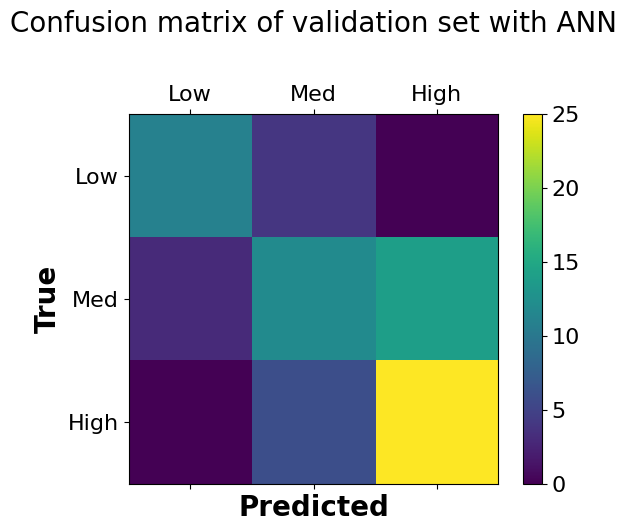

In [34]:
labels=['Low','Med','High']
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(cm_ann,cmap=plt.get_cmap('viridis'))
ax.set_title('Confusion matrix of validation set with ANN',fontsize=20,x=0.5,y=1.2)
cbar=fig.colorbar(cax) 
cbar.ax.tick_params(labelsize=16)
#fig.colorbar(cax)
ax.set_xticklabels(['']+labels,fontsize=16)
ax.set_yticklabels(['']+labels,fontsize=16)
plt.xlabel('Predicted',fontsize=20,fontweight='bold')
plt.ylabel('True',fontsize=20,fontweight='bold')
plt.savefig("CM_ANN.tiff",format='tiff',dpi=600,bbox_inches='tight',orientation='landscape')
plt.show()

random forest

In [35]:
import os
import sys
os.environ["PYTHONUTF8"]="1"
os.environ["PYTHONIOENCODING"]="utf-8"

try:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import BaggingClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV

    rf_pipeline = ImbPipeline([("smote", SMOTE(random_state=50)),
                               #("scaler", StandardScaler()), 
                               ("rf", RandomForestClassifier(random_state=50, class_weight="balanced"))])
    skf_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
    #choosing the best set of hyperparameters
    param_dist_rf =  { "rf__n_estimators" :[10,20,30,40,50],"rf__max_depth": [10, 20, None],"rf__min_samples_split": [2, 5, 10],
                       "rf__min_samples_leaf": [1, 2, 4],"rf__max_features": [3,4,5,"sqrt", "log2"],"rf__class_weight": ["balanced", "balanced_subsample"] }
    random_search_rf = RandomizedSearchCV(estimator=rf_pipeline,param_distributions=param_dist_rf,n_iter=50,cv=skf_rf,scoring="accuracy",n_jobs=1,
    verbose=1,random_state=50)
    # 训练
    random_search_rf.fit(X_train_val, y_train_val)
    best_params_rf=random_search_rf.best_params_
    print (random_search_rf.best_params_)
    print(f"Optimal accuracy of random forest cross validation: {random_search_rf.best_score_:.4f}")
    print(f"RF cross validation accuracy (mean ± standard deviation): {random_search_rf.cv_results_['mean_test_score'].mean():.4f} ± {random_search_rf.cv_results_['mean_test_score'].std():.4f}")
    print(f"Cross validation accuracy (per fold): {random_search_rf.cv_results_['mean_test_score']}")
except Exception as e:
   print(f"error:{e}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'rf__n_estimators': 50, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 4, 'rf__max_depth': 10, 'rf__class_weight': 'balanced'}
Optimal accuracy of random forest cross validation: 0.7492
RF cross validation accuracy (mean ± standard deviation): 0.7269 ± 0.0135
Cross validation accuracy (per fold): [0.72576271 0.73237288 0.71576271 0.70909605 0.74242938 0.72576271
 0.70553672 0.74576271 0.72570621 0.74248588 0.74248588 0.73909605
 0.70559322 0.73909605 0.71570621 0.73570621 0.71903955 0.72581921
 0.72581921 0.72909605 0.73248588 0.71242938 0.73570621 0.71564972
 0.70892655 0.72559322 0.74909605 0.73576271 0.71920904 0.72237288
 0.72559322 0.73909605 0.74248588 0.70237288 0.72915254 0.74915254
 0.69898305 0.71570621 0.72576271 0.72581921 0.73581921 0.72570621
 0.74237288 0.72225989 0.74254237 0.72248588 0.68892655 0.73564972
 0.72920904 0.73909605]


In [36]:
#training the model
# ========== Train the final random forest model ==========
best_rf = RandomForestClassifier(
    n_estimators=random_search_rf.best_params_["rf__n_estimators"],
    max_depth=random_search_rf.best_params_["rf__max_depth"],
    min_samples_split=random_search_rf.best_params_["rf__min_samples_split"],
    min_samples_leaf=random_search_rf.best_params_["rf__min_samples_leaf"],
    max_features=random_search_rf.best_params_["rf__max_features"],
    class_weight=random_search_rf.best_params_["rf__class_weight"],
    n_jobs=1,
    random_state=50)

smote = SMOTE(random_state=50, k_neighbors=5)  # k_neighbors adjusted based on sample size
X_train_val_smote_rf, y_train_val_smote_rf = smote.fit_resample(X_train_val, y_train_val)
print(f"SMOTE training set sample size: {X_train_val_smote_rf.shape[0]} (Original: {X_train_val.shape[0]})")
check_data_distribution(y_train_val_smote_rf)
best_rf.fit(X_train_val_smote_rf, y_train_val_smote_rf)

# ========== Model evaluation ==========
# prediction
y_rf_train_pred = best_rf.predict(X_train_val)
y_rf_test_pred = best_rf.predict(X_test)
y_rf_test_prob = best_rf.predict_proba(X_test)  # Probability is used to calibrate the curve


#testing the model
from sklearn import metrics
model_score = best_rf.score(X_test, y_test)
print ("Model Score for RF on actual Data %.2f \n" % (model_score))

train_score = best_rf.score(X_train_val, y_train_val)
print ("Model Score for RF on training Data %.2f \n" % (train_score))
# accuracy
rf_train_acc = accuracy_score(y_train_val, y_rf_train_pred)
rf_test_acc = accuracy_score(y_test, y_rf_test_pred)
print(f"\nAccuracy of Random Forest Training Set: {rf_train_acc:.4f}")
print(f"Accuracy of Random Forest Test Set: {rf_test_acc:.4f}")
#Detailed evaluation
print("\n=== Detailed Evaluation Report on Random Forest Test Set ===")
print(classification_report(y_test, y_rf_test_pred))

SMOTE training set sample size: 369 (Original: 299)
=== Category distribution ===
3.0    33.333333
2.0    33.333333
1.0    33.333333
Name: proportion, dtype: float64
Model Score for RF on actual Data 0.73 

Model Score for RF on training Data 0.97 


Accuracy of Random Forest Training Set: 0.9666
Accuracy of Random Forest Test Set: 0.7333

=== Detailed Evaluation Report on Random Forest Test Set ===
              precision    recall  f1-score   support

         1.0       0.67      0.80      0.73        15
         2.0       0.67      0.69      0.68        29
         3.0       0.85      0.74      0.79        31

    accuracy                           0.73        75
   macro avg       0.73      0.74      0.73        75
weighted avg       0.74      0.73      0.74        75



In [37]:

from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test,y_rf_test_pred)
print ("Confusion Matrix \n", confusion_matrix(y_test,y_rf_test_pred))

from sklearn.metrics import precision_score
print ("Precision scores across classes: ", precision_score(y_test,y_rf_test_pred,average=None), "\n")

from sklearn.metrics import recall_score
print ("Recall scores across classes: ", recall_score(y_test,y_rf_test_pred,average=None), "\n")

from sklearn.metrics import precision_score
print ("Macro Precision score: ",precision_score(y_test,y_rf_test_pred,average='macro'), "\n")

from sklearn.metrics import recall_score
print ("Macro Recall score: ", recall_score(y_test,y_rf_test_pred,average='macro'), "\n")

Confusion Matrix 
 [[12  3  0]
 [ 5 20  4]
 [ 1  7 23]]
Precision scores across classes:  [0.66666667 0.66666667 0.85185185] 

Recall scores across classes:  [0.8        0.68965517 0.74193548] 

Macro Precision score:  0.7283950617283951 

Macro Recall score:  0.7438635520949203 



In [38]:
#getting percentage values for confusion matrix
np.true_divide(cm_rf,75)*100

array([[16.        ,  4.        ,  0.        ],
       [ 6.66666667, 26.66666667,  5.33333333],
       [ 1.33333333,  9.33333333, 30.66666667]])

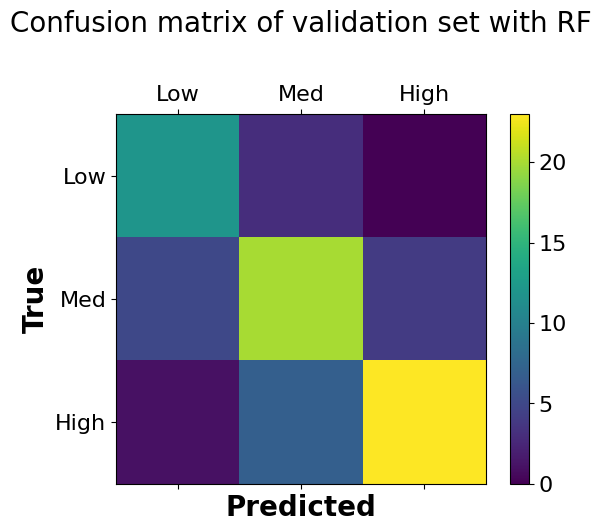

In [39]:
labels = ['Low', 'Med', 'High']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_rf, cmap=plt.get_cmap('viridis'))
ax.set_title('Confusion matrix of validation set with RF', fontsize=20, x=0.5, y=1.2)
cbar=fig.colorbar(cax)
cbar.ax.tick_params(labelsize=16)
ax.set_xticklabels([''] + labels,fontsize=16)
ax.set_yticklabels([''] + labels,fontsize=16)
plt.xlabel('Predicted', fontsize=20, fontweight = 'bold')
plt.ylabel('True', fontsize=20,  fontweight = 'bold')
plt.savefig("CM_RF.tiff",format ='tiff', dpi=600, bbox_inches='tight',orientation='landscape')
plt.show()

SHAP value with RF

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit
sss_rf=StratifiedShuffleSplit(n_splits=1,train_size=min(200,len(X_train_val)),random_state=42)
for train_index,_ in sss_rf.split(X_train_val,y_train_val):
     background_rf=X_train_val[train_index]
     print(f"Background data shape：{background_rf.shape}")

Background data shape：(200, 9)


RF SHAP value

SHAP value type：<class 'list'>
multi-class classification，have3class


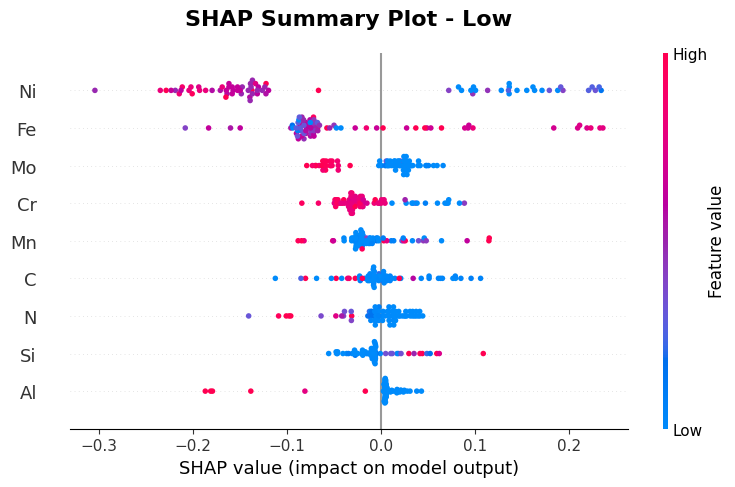

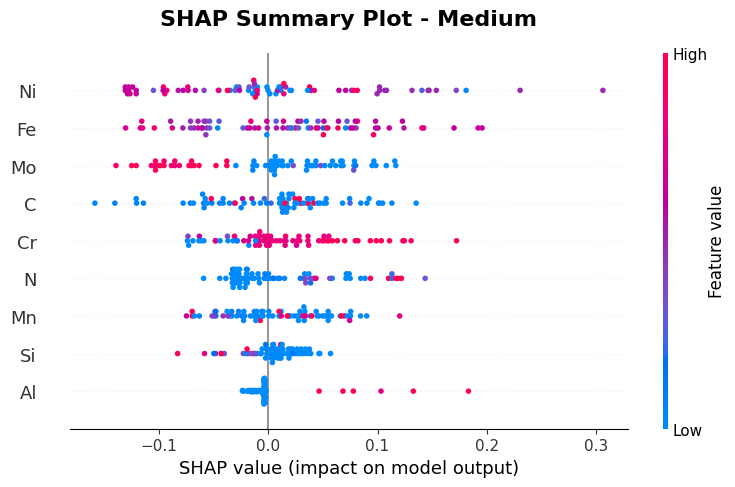

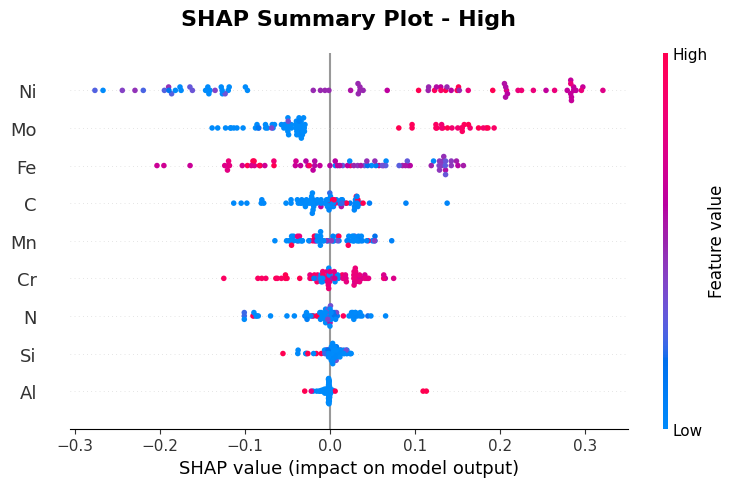

In [41]:
#Set research level style
plt.style.use('default')#Maintain consistency using default styles
plt.rcParams.update({'font.size':14,
                     
                     'mathtext.fontset':'stix','axes.labelsize':14,
                   'axes.titlesize':16,'xtick.labelsize':14,'ytick.labelsize':14,'legend.fontsize':14,'figure.titlesize':20})

#Extract a list of original feature names
feature_names_SHAP=['C','N','Ni','Al','Fe','Mo','Mn','Si','Cr']
feature_names_SHAP=list(feature_names_SHAP)
#Ensure that the number of feature names matches the feature dimensions
if len(feature_names_SHAP)!=X_train_val.shape[1]:
    feature_names_SHAP=[f'element_{i}'for i in range(X_train_val.shape[1])]
    print(f"Warning: The number of feature names does not match, using default names：{feature_names_SHAP}")
    

explainer_rf=shap.TreeExplainer(best_rf)
shap_values_rf=explainer_rf.shap_values(X_test[:200],check_additivity=False)
print(f"SHAP value type：{type(shap_values_rf)}")



class_names_list=["Low","Medium","High"]
if isinstance(shap_values_rf,list):
    if len(shap_values_rf[0].shape) == 2: 
    
        n_classes_rf = len(shap_values_rf)
    
        print(f"multi-class classification，have{n_classes_rf}class")
    
    for class_idx_rf in range(n_classes_rf):
        
        plt.figure(figsize=(10,8))
        
        class_shap_rf = shap_values_rf[class_idx_rf]
        shap.summary_plot(
            class_shap_rf,
            features=X_test[:200],
            feature_names=feature_names_SHAP,
            plot_type="dot",
            show=False,
            
        )
        if class_idx_rf< len(class_names_list):
            class_name=class_names_list[class_idx_rf]
        else:
            class_name=f"Class {class_idx_rf}"
        
        
        
        plt.title(f"SHAP Summary Plot - {class_name}",fontsize=16,fontweight='bold',pad=20)
        plt.tight_layout()
        plt.savefig(f"SHAP Summary Plot - {class_name}_RF.tiff",format='tiff',dpi=600,bbox_inches='tight')
        plt.show()
   
elif len(shap_values_rf.shape)==2:
    print(f"Binary classification, SHAP value shape：{shap_values_rf.shape}")
else:
    print(f"Unknown format, shape：{shap_values_rf.shape}")


In [42]:
def detailed_calibration_visualization_rf(y_true_bin,y_prob,class_names):
    """
    Detailed calibration visualization analysis
    """
    fig, axes=plt.subplots(1,3,figsize=(15,5))
    axes=axes.ravel()
    fig.suptitle('Probabilistic calibration curve with RF',fontsize=20,y=0.98)
    class_names=['Low SFE','Medium SFE','High SFE']
    for i in range(3):
        #Obtain the true label and predicted probability of the current category
        y_true_class=y_true_bin[:,i]
        y_prob_class=y_prob[:,i]
        prob_true,prob_pred=calibration_curve(y_true_class,y_prob_class,n_bins=10,strategy='quantile')
        #plot a curve
        
        axes[i].plot(prob_pred,prob_true,'o-',label=class_names[i],markersize=6,linewidth=2)
        
        axes[i].plot([0,1],[0,1],'k--',label='Ideal calibration',linewidth=1.5)
        
        axes[i].set_xlabel('Mean Predicted Probability',fontsize=11)
        
        axes[i].set_ylabel('Fraction of Positives',fontsize=11)
        
        axes[i].set_title(f'Calibration Curve - {class_names[i]}')
       
        axes[i].legend(loc='best',fontsize=10)
        
        axes[i].grid(True,alpha=0.3)
        
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.savefig("Probabilistic calbration curve_RF.tiff",format='tiff',dpi=600,bbox_inches='tight')
    plt.show()

category1(Low SFE) - collected7points
category2(Medium SFE) - collected10points
category3(High SFE) - collected10points
=== Probability calibration curve analysis===

---Low SFE analysis---
Mean absolute variance：0.0370
Points higher than the diagonal：0/10
Points below the diagonal：6/10
Calibration quality：Excellent calibration

---Medium SFE analysis---
Mean absolute variance：0.1168
Points higher than the diagonal：3/10
Points below the diagonal：7/10
Calibration quality：General calibration

---High SFE analysis---
Mean absolute variance：0.0882
Points higher than the diagonal：6/10
Points below the diagonal：4/10
Calibration quality：Good calibration

【Low SFEPattern Analysis】
Mode: Good Calibration
- The predicted probability is basically consistent with the actual probability
    regression slope：0.935732,intercept：-0.016

【Medium SFEPattern Analysis】
Mode: Good Calibration
- The predicted probability is basically consistent with the actual probability
    regression slope：0.864104,inter

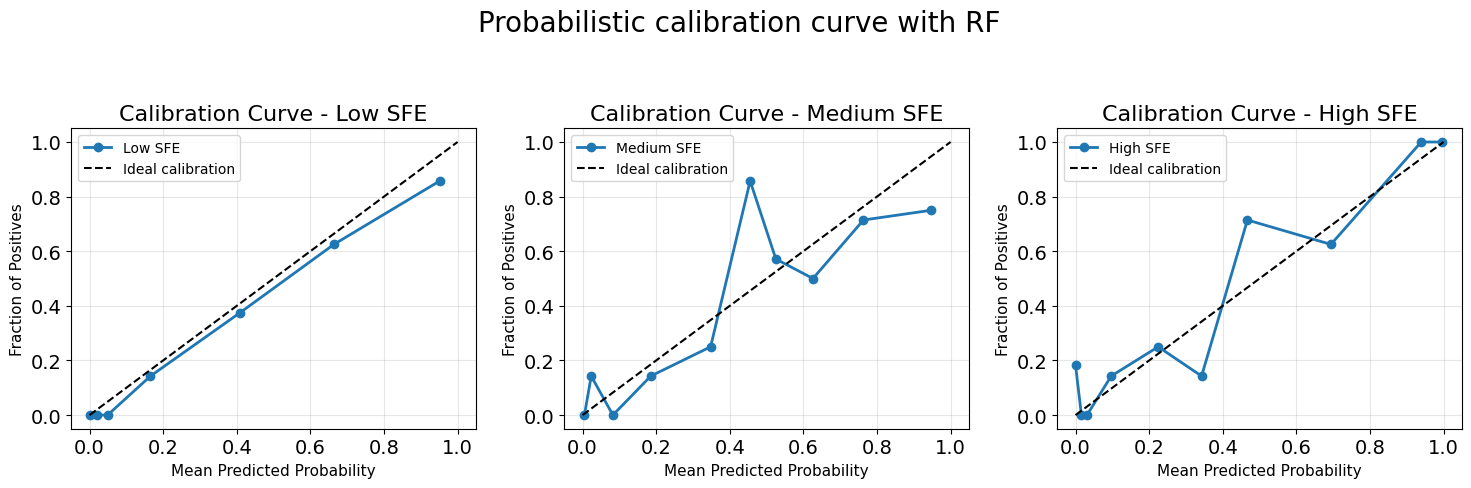

In [43]:
from sklearn.calibration import CalibratedClassifierCV
#Convert multi classification to binary format
y_test_bin_rf=label_binarize(y_test,classes=[1,2,3])
#Probabilistic calbration curve

class_names=['Low SFE','Medium SFE','High SFE']
#Collect calibration curve data
prob_true_list_rf=[]
prob_pred_list_rf=[]

for i in range(3):
    #Obtain the true label and predicted probability of the current category
    y_true_class_rf=y_test_bin_rf[:,i]
    y_prob_class_rf=y_rf_test_prob[:,i]
    #Ensure sufficient positive and negative samples
    if len(np.unique(y_true_class_rf))>1:
        prob_true_rf,prob_pred_rf=calibration_curve(y_true_class_rf,y_prob_class_rf,n_bins=10,strategy='quantile')
        prob_true_list_rf.append(prob_true_rf)
        prob_pred_list_rf.append(prob_pred_rf)
        print(f"category{i+1}({class_names[i]}) - collected{len(prob_true_rf)}points")
    else:
        print(f"Warning: Category{i+1}({class_names[i]})Insufficient samples, skip")
        #Add an empty array to maintain index consistency
        prob_true_list_rf.append(np.array([]))
        prob_pred_list_rf.append(np.array([]))
        print(f"prob_true_list_rf length：{len(prob_true_list_rf)}")
        print(f"prob_pred_list_rf length：{len(prob_pred_list_rf)}")

#execute analysis
if len(prob_true_list_rf)>=3:
    analyze_calibration_curves(prob_true_list_rf,prob_pred_list_rf,class_names)
    for i in range(3):
        if len(prob_true_list_rf[i])>0:
            identify_calibration_patterns(prob_true_list_rf[i],prob_pred_list_rf[i],class_names[i])
        else:
            print(f"skip class{class_names[i]} - no data")
    metrics=quantitative_calibration_analysis(y_test_bin_rf,y_rf_test_prob,class_names)
    detailed_calibration_visualization_rf(y_test_bin_rf,y_rf_test_prob,class_names)
else:
    print("Error：No enough calibration curve data available")

variance in feature importance

feature_name:['C', 'N', 'Ni', 'Al', 'Fe', 'Mo', 'Mn', 'Si', 'Cr']
===== feature（including variance） =====
  feature  importance_mean  importance_std  importance_var
0      Ni         0.124444        0.039901        0.001592
1      Fe         0.088444        0.037315        0.001392
2      Mo         0.044889        0.028490        0.000812
3       C         0.036889        0.029551        0.000873
4      Mn         0.036000        0.026477        0.000701
5      Al         0.009333        0.007813        0.000061
6       N         0.005333        0.027670        0.000766
7      Si         0.003111        0.017104        0.000293
8      Cr        -0.013333        0.025762        0.000664


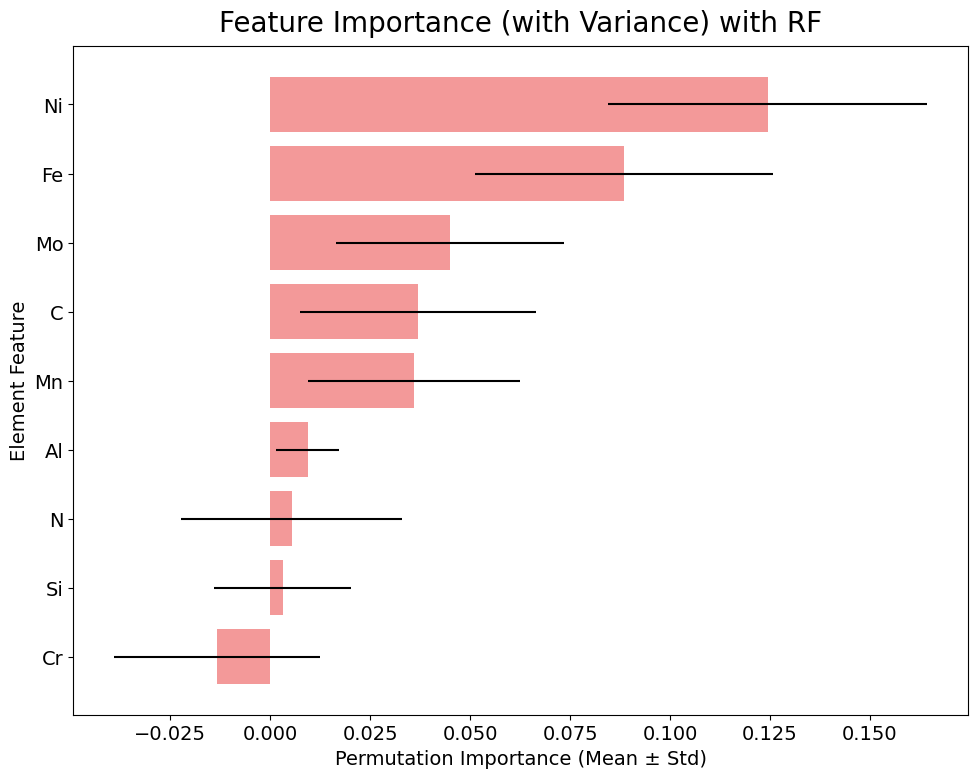

In [44]:
# feature name（Column corresponding to NormElements：C, N, Ni, Al, Fe, Mo, Mn, Si, Cr）
feature_names = ini_dataset_5.columns.values[0:9].tolist()  # Retrieve feature names from ini_dataset_5
print(f"feature_name:{feature_names}")
# Call function (calculated using test set X_test to avoid overfitting)
importance_result = get_permutation_importance_variance(
    model=best_rf,
    X=X_test,  # Evaluate with an independent test set
    y=y_test,
    feature_names=feature_names,
    n_repeats=30,  # Replace repetition times
    task_type="classification",  # classification task
    scoring="accuracy",  # Classification task rating indicators
    return_df=True  # return DataFrame format
)


# ========== output result ==========
print("===== feature（including variance） =====")
print(importance_result)


# ========== Visualization ==========
import matplotlib.pyplot as plt

def plot_importance_with_variance(importance_df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 8))
    plt.barh(
        importance_df["feature"],
        importance_df["importance_mean"],
        xerr=importance_df["importance_std"],  # Error bar=standard deviation (reflecting variance)
        color="lightcoral",
        alpha=0.8
    )
    plt.xlabel("Permutation Importance (Mean ± Std)")
    plt.ylabel("Element Feature")
    plt.title(title,fontsize=20,y=1.01)
    plt.gca().invert_yaxis()  # Sort in descending order from top to bottom
    plt.tight_layout()
    plt.savefig(f"Feature Importance (with Variance) with RF.tiff",format='tiff',dpi=600,bbox_inches='tight')
    plt.show()
# Draw feature importance (including variance)
plot_importance_with_variance(
    importance_result,
    "Feature Importance (with Variance) with RF"
)

In [45]:
#Obtain validation set prediction probability and uncertainty
print("\ncalculate prediction probability and uncertainty...")
#obtain all trees prediction probability
tree_probabilities_rf = []

# obtain tree number
n_trees_rf =  len(best_rf.estimators_)

# Traverse each tree (from the first to the last)
for tree_idx in range(1, n_trees_rf + 1):
    # Take the tree_idx trees in front
    sub_trees = best_rf.estimators_[:tree_idx]
    # Predict each tree one by one and then merge probabilities
    sub_probs = []
    for tree in sub_trees:
        prob = tree.predict_proba(X_test)  # Prediction probability of a single tree
        sub_probs.append(prob)
    # Calculate the average probability of the previous tree_idx trees (or directly store the probability of all trees)
    avg_probs = np.mean(sub_probs, axis=0)
    tree_probabilities_rf.append(avg_probs)


# Verification result: Output the predicted probability shape of the first tree
print(f"Single tree prediction probability shape：{tree_probabilities_rf[0].shape}")  # should be(n_samples, n_classes)
#Calculate the average probability
y_pred_proba=np.mean(tree_probabilities_rf,axis=0)
#prediction class
y_pred=np.argmax(y_pred_proba,axis=1)+1
#Calculate the uncertainty of predictions
# method 1：Standard deviation of prediction probability (calculated separately for each category)
prob_std=np.std(tree_probabilities_rf,axis=0)
# Method 2: Confidence (maximum probability)
confidence=np.max(y_pred_proba,axis=1)
#Method 3: Uncertainty Indicator (1- Maximum Probability)
uncertainty=1-confidence
#Method 4: Entropy (a measure of uncertainty in information theory)
entropy=-np.sum(y_pred_proba*np.log(y_pred_proba+1e-10),axis=1)
#Method 5: Quantile of prediction interval (for maximum probability category)
alpha=0.05#95% confidence interval
#Calculate the confidence interval of the probability for the maximum probability category of each sample
pre_class_indices=y_pred-1
prob_intervals=[]
for i in range(len(X_test)):
    #Obtain all tree prediction probabilities for the predicted category
    class_prob_samples = [tree[i][pre_class_indices[i]] for tree in tree_probabilities_rf]
#Calculate quantile interval
    lower_bound=np.percentile(class_prob_samples,(alpha/2)*100)
    upper_bound=np.percentile(class_prob_samples,(1-alpha/2)*100)
    mean_prob=np.mean(class_prob_samples)
    prob_intervals.append({'pred_class':pre_class_indices[i],'mean_prob':mean_prob,'lower_bound':lower_bound,'upper_bound':upper_bound,
    'interval_width':upper_bound-lower_bound})
    prob_intervals_df=pd.DataFrame(prob_intervals)
#5.Output prediction uncertainty and interval information
print("\n"+"="*60)
print("Uncertainty of prediction on the validation set and confidence interval")
print("="*60)
#Create a DataFrame containing prediction information
results_df=pd.DataFrame({'true class':y_test,'prediction class':y_pred,'right prediction':y_test==y_pred,'confidence':confidence,'uncertainty':uncertainty,'entropy':entropy,
'Maximum probability category':np.argmax(y_pred_proba,axis=1),'maximum probability':np.max(y_pred_proba,axis=1)})
#Add the predicted probabilities of various categories
for i in range(best_rf.n_classes_):
    results_df[f'class{i}_probability']=y_pred_proba[:,i]
    results_df[f'class{i}_Probability standard deviation']=prob_std[:,i]
print(f"\nPrediction uncertainty and confidence intervals for the first 10 samples({100*(1-alpha)}%confidence level：)")
sample_info=pd.DataFrame({'true class':y_test[:10],'prediction class':y_pred[:10],'right prediction':results_df['right prediction'][:10],'confidence':confidence[:10].round(4),
'uncertainty':uncertainty[:10].round(4),'maximum probability':results_df['maximum probability'][:10].round(4),'lower bound of probability':prob_intervals_df['lower_bound'][:10].round(4),
'upper bound of probability':prob_intervals_df['upper_bound'][:10].round(4),'interval width':prob_intervals_df['interval_width'][:10].round(4)})
print(sample_info)
#print(prob_intervals[:5])
print(f"\nStatistical Summary of Uncertainty and Confidence Intervals：")
print(f"Average confidence level：{confidence.mean():.4f}")
print(f"Standard deviation of confidence level：{confidence.std():.4f}")
print(f"average uncertainty：{uncertainty.mean():.4f}")
print(f"average entropy：{entropy.mean():.4f}")
print(f"Average probability interval width：{prob_intervals_df['interval_width'].mean():4f}")

#Statistics grouped by prediction accuracy
print(f"\nUncertainty statistics grouped by prediction accuracy：")
correct_stats=results_df.groupby('right prediction').agg({'confidence':['mean','std','min','max'],'uncertainty':['mean','std'],'entropy':['mean','std']}).round(4)
print(correct_stats)


calculate prediction probability and uncertainty...
Single tree prediction probability shape：(75, 3)

Uncertainty of prediction on the validation set and confidence interval

Prediction uncertainty and confidence intervals for the first 10 samples(95.0%confidence level：)
   true class  prediction class  right prediction  confidence  uncertainty  \
0         1.0                 1              True      0.9590       0.0410   
1         1.0                 2             False      0.7301       0.2699   
2         3.0                 3              True      0.6791       0.3209   
3         3.0                 3              True      0.9413       0.0587   
4         1.0                 1              True      0.9590       0.0410   
5         2.0                 1             False      0.5443       0.4557   
6         3.0                 3              True      0.9734       0.0266   
7         1.0                 1              True      0.8541       0.1459   
8         3.0            

<function matplotlib.pyplot.show(close=None, block=None)>

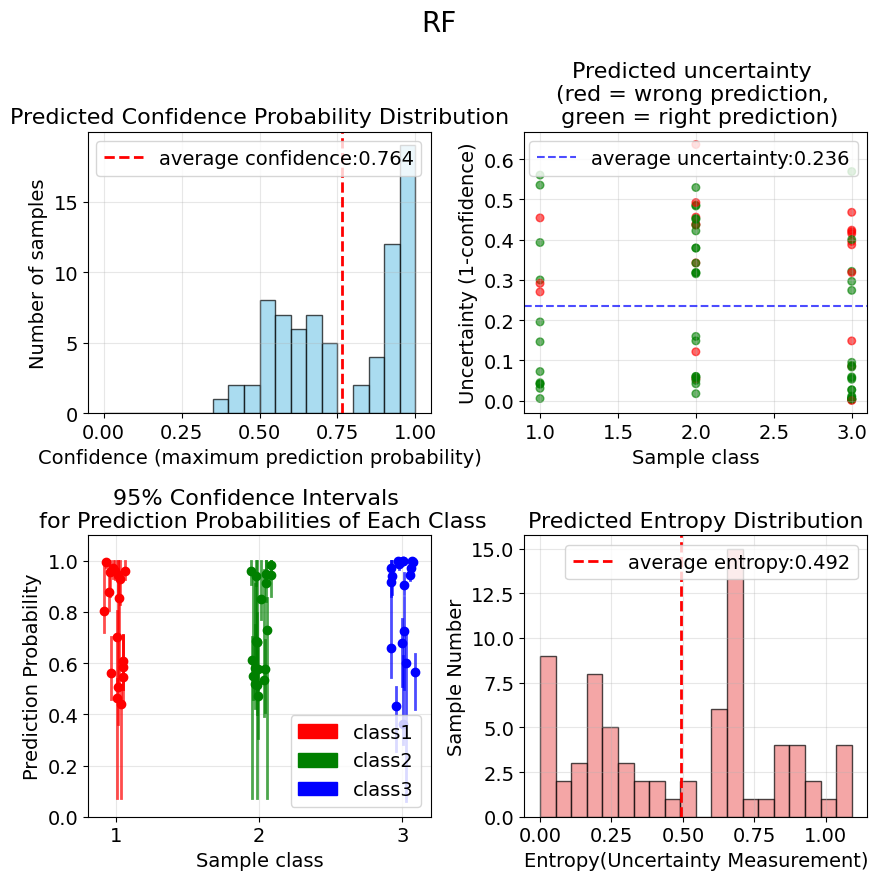

In [46]:
from matplotlib.patches import Patch
#Visualizing prediction uncertainty and confidence intervals
fig,axes=plt.subplots(2,2,figsize=(9,9))
fig.suptitle('RF',fontsize=20,y=0.98)
#Subgraph 1: Confidence Distribution
bins=np.linspace(0,1,21)
axes[0,0].hist(confidence,bins=bins,alpha=0.7,color='skyblue',edgecolor='black')
axes[0,0].axvline(confidence.mean(),color='red',linestyle='--',linewidth=2,label=f'average confidence:{confidence.mean():.3f}')
axes[0,0].set_xlabel('Confidence (maximum prediction probability)')
axes[0,0].set_ylabel('Number of samples')
axes[0,0].set_title('Predicted Confidence Probability Distribution')
axes[0,0].legend()
axes[0,0].grid(True,alpha=0.3)
#Subgraph 2: Relationship between Uncertainty and Prediction Accuracy
correct_colors=['red'if not c else 'green' for c in results_df['right prediction']]
axes[0,1].scatter(results_df['true class'],uncertainty,c=correct_colors,alpha=0.6,s=30)
axes[0,1].axhline(uncertainty.mean(),color='blue',linestyle='--',alpha=0.7,label=f'average uncertainty:{uncertainty.mean():.3f}')
axes[0,1].set_xlabel('Sample class')
axes[0,1].set_ylabel('Uncertainty (1-confidence)')
axes[0,1].set_title('Predicted uncertainty \n(red = wrong prediction, \n green = right prediction)')
axes[0,1].legend()
axes[0,1].grid(True,alpha=0.3)
#Subgraph 3: Prediction Probability Intervals for Each Category
class_colors=['red','green','blue']
# Define the categories corresponding to the abscissa (1, 2, 3)
class_x_pos = {1: 1, 2: 2, 3: 3}  # Category → Abscissa position
for class_idx in range(best_rf.n_classes_):
    #Select samples predicted to be of this category
    current_class = class_idx + 1  # true class（1、2、3）
    class_mask = results_df['prediction class'] == current_class
    if np.sum(class_mask)>0:
        class_indices=np.where(class_mask)[0][:min(20,np.sum(class_mask))]#Display a maximum of 20
        #Add slight jitter to samples of the same category (to avoid overlap)
        jitter = np.random.normal(0, 0.05, size=len(class_indices))  # Small-range random jitter
        x_pos = class_x_pos[current_class] + jitter  # Category corresponds to the abscissa + jitter
        for i, idx in enumerate(class_indices):
            interval=prob_intervals_df.iloc[idx]
            axes[1,0].plot([x_pos[i], x_pos[i]],[interval['lower_bound'],interval['upper_bound']],color=class_colors[class_idx],alpha=0.7,linewidth=2)
            axes[1,0].plot(x_pos[i],interval['mean_prob'],'o',color=class_colors[class_idx],markersize=6)
axes[1,0].set_xticks([1, 2, 3])
axes[1,0].set_xlabel('Sample class')  # Modify the X-axis label
axes[1,0].set_ylabel('Prediction Probability')
axes[1,0].set_title('95% Confidence Intervals \n for Prediction Probabilities of Each Class')
legend_elements = [
    Patch(facecolor='red', edgecolor='red', label='class1'),  # class1 Corresponding to red
    Patch(facecolor='green', edgecolor='green', label='class2'),  # class2 Corresponding to green
    Patch(facecolor='blue', edgecolor='blue', label='class3')  # class3 Corresponding to blue
]
axes[1,0].legend(handles=legend_elements, loc='lower right')
axes[1,0].grid(True,alpha=0.3)
axes[1,0].set_ylim(0,1.1)
#Subgraph 4: Entropy Distribution
axes[1,1].hist(entropy,bins=20,alpha=0.7,color='lightcoral',edgecolor='black')
axes[1,1].axvline(entropy.mean(),color='red',linestyle='--',linewidth=2,label=f'average entropy:{entropy.mean():.3f}')
axes[1,1].set_xlabel('Entropy(Uncertainty Measurement)')
axes[1,1].set_ylabel('Sample Number')
axes[1,1].set_title('Predicted Entropy Distribution')
axes[1,1].legend()
axes[1,1].grid(True,alpha=0.3)
plt.tight_layout()
plt.savefig("Prediction interval_RF.tiff",format ='tiff', dpi=600, bbox_inches='tight',orientation='landscape')
plt.show

XGBoost

In [47]:
# Suppose your original labels are y_train_val、y_test（value is 1/2/3）
y_train_val_xgb = y_train_val - 1  # convert into 0/1/2
y_test_xgb = y_test - 1            # convert into 0/1/2
pipeline_xgb = ImbPipeline([
    ("smote", SMOTE(random_state=50)),  # Step 1: SMOTE (executed only on the training subset of each fold)
    #("scaler", StandardScaler()),       # Step 2: Standardization (fitting only on the training subset)
    ("xgb", xgb.XGBClassifier(          # Step 3: XGBoost (named "xgb")
        objective='multi:softmax',
        num_class=3,
        random_state=50,
        verbosity=0
    ))
])
# -------------------------- Hyperparameter search space (for XGBoost)--------------------------
# Note: The parameter name must correspond to the name of the model in the pipeline (the default name of xgb.XGBClassifier is xgbclassifier)
param_dist_xgb = {
    'xgb__max_depth': [3, 5, 6],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}
# -------------------------- 5-fold cross-validation (stratified + random search) --------------------------
# Stratified 5-fold (ensure that the category distribution of each fold is consistent, suitable for imbalanced classification)
skf_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Random search: pipeline + hyperparameters + 5-fold cross-validation
random_search_xgb = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,  # Search for 20 sets of hyperparameters (can be adjusted according to requirements)
    cv=skf_xgb,     # Stratified 5-fold cross-validation
    scoring='accuracy',  #Evaluation metrics (can be replaced with f1_macro, etc., suitable for imbalanced classification)
    n_jobs=1,  
    random_state=50,
    verbose=1   # Display training logs
)

# Training (automatic execution: SMOTE per fold → standardization → training XGBoost → validation)
random_search_xgb.fit(X_train_val, y_train_val_xgb)
# -------------------------- Result Evaluation --------------------------
# Output the optimal hyperparameters and cross-validation results
print("\n===== Extract the optimal parameters of XGBoost =====")
# Filter out the XGBoost parameters from best_params_ (remove the "xgb__" prefix)
best_xgb_params = {}
for key, value in random_search_xgb.best_params_.items():
    if key.startswith("xgb__"):  # Only retain the parameters of XGBoost
        new_key = key.replace("xgb__", "")  # Remove the prefix
        best_xgb_params[new_key] = value
        print(f"{new_key}: {value}")

print (random_search_xgb.best_params_)
print(f"XGBoost Optimal accuracy of cross-validation: {random_search_xgb.best_score_:.4f}")
print(f"XGBoost Cross-validation accuracy (mean ± standard deviation): {random_search_xgb.cv_results_['mean_test_score'].mean():.4f} ± {random_search_xgb.cv_results_['mean_test_score'].std():.4f}")
print(f"XGBoost Cross-validation accuracy (each fold): {random_search_xgb.cv_results_['mean_test_score']}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

===== Extract the optimal parameters of XGBoost =====
subsample: 0.8
n_estimators: 100
max_depth: 6
learning_rate: 0.2
colsample_bytree: 0.7
{'xgb__subsample': 0.8, 'xgb__n_estimators': 100, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.2, 'xgb__colsample_bytree': 0.7}
XGBoost Optimal accuracy of cross-validation: 0.7491
XGBoost Cross-validation accuracy (mean ± standard deviation): 0.7270 ± 0.0103
XGBoost Cross-validation accuracy (each fold): [0.73231638 0.73570621 0.73570621 0.71915254 0.73225989 0.72564972
 0.71898305 0.74909605 0.73225989 0.72231638 0.71903955 0.72559322
 0.70237288 0.71576271 0.72225989 0.73581921 0.74248588 0.72242938
 0.73237288 0.71898305]


In [48]:
#training the model
# ==========Train the final XGBoost model ==========
print("best_xgb_params content：", best_xgb_params)
best_xgb = xgb.XGBClassifier(
    **best_xgb_params,  # Import the optimal parameters
    objective='multi:softmax',  # Required parameters for three-class classification
    num_class=3,                # Number of categories (corresponding to 1/2/3, converted to 0/1/2)
    random_state=50,
    verbosity=0,
    base_score=float(0.5)  # Explicitly specify it as a floating-point number to avoid string formatting issues
)

smote_xgb = SMOTE(random_state=50, k_neighbors=5)  # k_neighbors is adjusted according to the sample size
X_train_val_smote_xgb, y_train_val_smote_xgb = smote.fit_resample(X_train_val, y_train_val_xgb)
print(f"Number of samples in the training set after SMOTE: {X_train_val_smote_xgb.shape[0]} (original: {X_train_val.shape[0]})")
check_data_distribution(y_train_val_smote_xgb)
best_xgb.fit(X_train_val_smote_xgb, y_train_val_smote_xgb)


# ========== Model Evaluation ==========
# prediction
y_xgb_train_pred = best_xgb.predict(X_train_val)
y_xgb_test_pred = best_xgb.predict(X_test)
y_xgb_test_pred_1=y_xgb_test_pred+1
y_xgb_test_prob = best_xgb.predict_proba(X_test)  # Probability is used for calibration curves


#testing the model
from sklearn import metrics
model_score_xgb = best_xgb.score(X_test, y_test_xgb)
print ("Model Score for XGB on actual Data %.2f \n" % (model_score_xgb))

train_score_xgb = best_xgb.score(X_train_val, y_train_val_xgb)
print ("Model Score for XGB on training Data %.2f \n" % (train_score_xgb))
# accuracy
xgb_train_acc = accuracy_score( y_train_val_xgb, y_xgb_train_pred)
xgb_test_acc = accuracy_score(y_test_xgb, y_xgb_test_pred)
print(f"\nXGB Training set accuracy rate: {xgb_train_acc:.4f}")
print(f"XGB Test set accuracy rate: {xgb_test_acc:.4f}")
# Detailed evaluation
print("\n=== XGBoost detailed Evaluation Report of the Test Set ===")
print(classification_report(y_test_xgb, y_xgb_test_pred))

best_xgb_params content： {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Number of samples in the training set after SMOTE: 369 (original: 299)
=== Category distribution ===
2.0    33.333333
1.0    33.333333
0.0    33.333333
Name: proportion, dtype: float64
Model Score for XGB on actual Data 0.76 

Model Score for XGB on training Data 0.97 


XGB Training set accuracy rate: 0.9666
XGB Test set accuracy rate: 0.7600

=== XGBoost detailed Evaluation Report of the Test Set ===
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76        15
         1.0       0.68      0.79      0.73        29
         2.0       0.85      0.74      0.79        31

    accuracy                           0.76        75
   macro avg       0.77      0.76      0.76        75
weighted avg       0.77      0.76      0.76        75



In [49]:

from sklearn.metrics import confusion_matrix
cm_xgb = confusion_matrix(y_test_xgb,y_xgb_test_pred)
print ("Confusion Matrix \n", confusion_matrix(y_test_xgb,y_xgb_test_pred))

from sklearn.metrics import precision_score
print ("Precision scores across classes: ", precision_score(y_test_xgb,y_xgb_test_pred,average=None), "\n")

from sklearn.metrics import recall_score
print ("Recall scores across classes: ", recall_score(y_test_xgb,y_xgb_test_pred,average=None), "\n")

from sklearn.metrics import precision_score
print ("Macro Precision score: ",precision_score(y_test_xgb,y_xgb_test_pred,average='macro'), "\n")

from sklearn.metrics import recall_score
print ("Macro Recall score: ", recall_score(y_test_xgb,y_xgb_test_pred,average='macro'), "\n")

Confusion Matrix 
 [[11  3  1]
 [ 3 23  3]
 [ 0  8 23]]
Precision scores across classes:  [0.78571429 0.67647059 0.85185185] 

Recall scores across classes:  [0.73333333 0.79310345 0.74193548] 

Macro Precision score:  0.771345575267144 

Macro Recall score:  0.7561240884933879 



In [50]:
#getting percentage values for confusion matrix
np.true_divide(cm_xgb,75)*100

array([[14.66666667,  4.        ,  1.33333333],
       [ 4.        , 30.66666667,  4.        ],
       [ 0.        , 10.66666667, 30.66666667]])

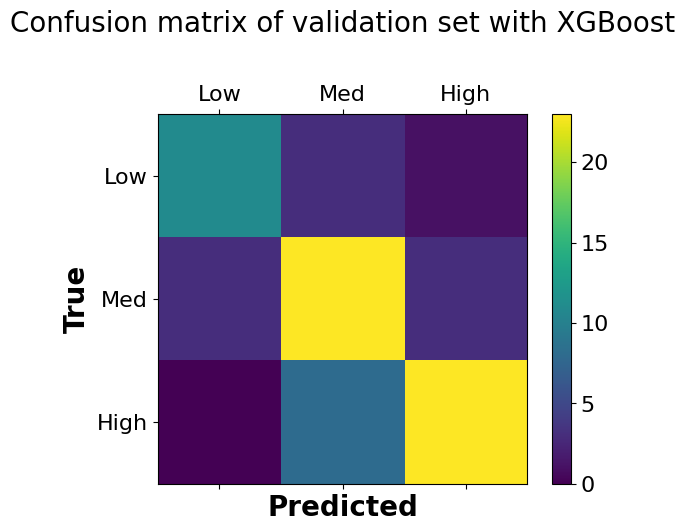

In [51]:
labels = ['Low', 'Med', 'High']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_xgb, cmap=plt.get_cmap('viridis'))
ax.set_title('Confusion matrix of validation set with XGBoost', fontsize=20, x=0.5, y=1.2)
cbar=fig.colorbar(cax)
cbar.ax.tick_params(labelsize=16)
ax.set_xticklabels([''] + labels,fontsize=16)
ax.set_yticklabels([''] + labels,fontsize=16)
plt.xlabel('Predicted', fontsize=20, fontweight = 'bold')
plt.ylabel('True', fontsize=20,  fontweight = 'bold')
plt.savefig("CM_XGBoost.tiff",format ='tiff', dpi=600, bbox_inches='tight',orientation='landscape')
plt.show()

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit
sss_xgb=StratifiedShuffleSplit(n_splits=1,train_size=min(200,len(X_train_val)),random_state=42)
for train_index,_ in sss_xgb.split(X_train_val,y_train_val_xgb):
     background_xgb=X_train_val[train_index]
     print(f"Background data shape：{background_xgb.shape}")

Background data shape：(200, 9)


SHAP value for XGBoost

model final base_score： 0.5
SHAP value type：<class 'shap._explanation.Explanation'>
Multi-class classification，have3class


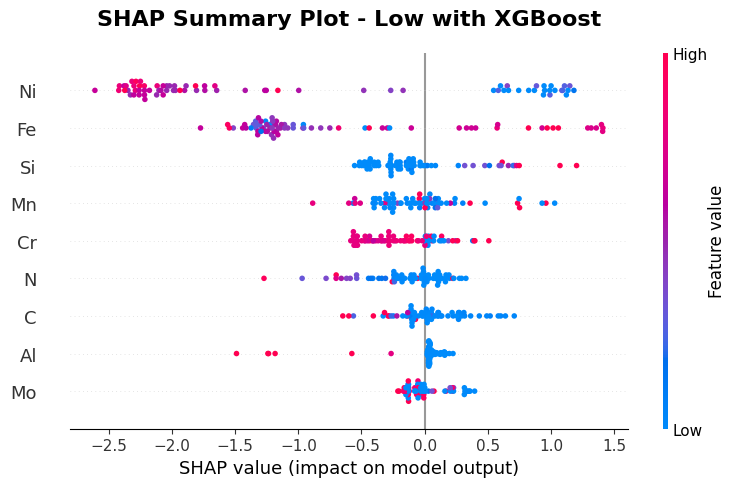

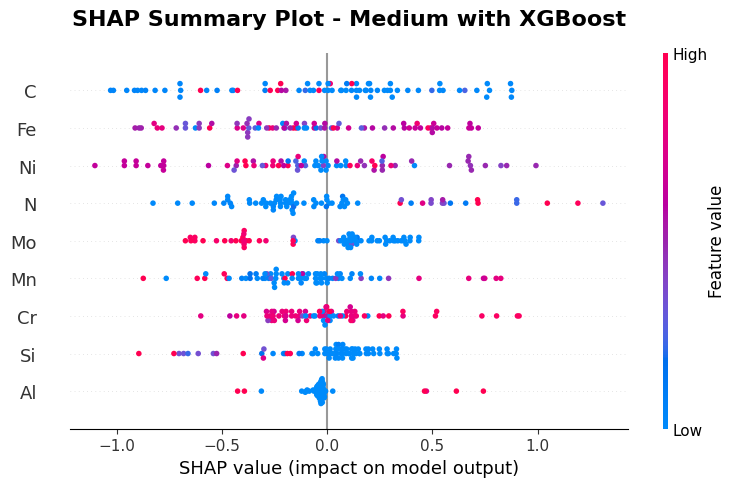

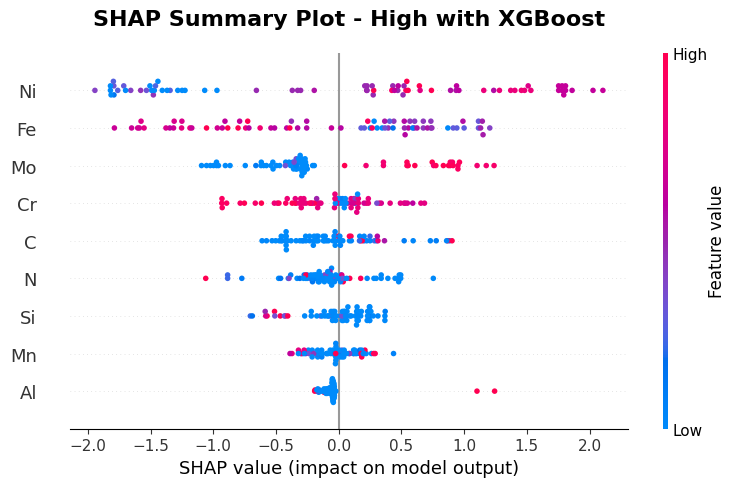

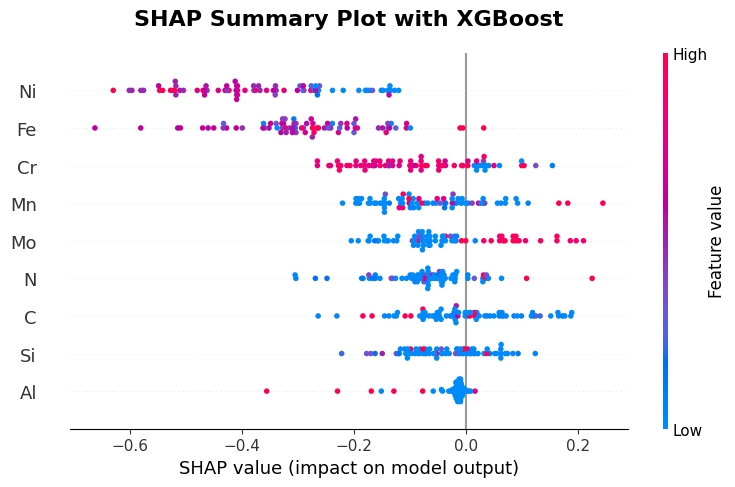

In [53]:
#Set a research-level style
plt.style.use('default')#Use the default style to maintain consistency
plt.rcParams.update({'font.size':14,
                     #'font.family':'serif',
                     'mathtext.fontset':'stix','axes.labelsize':14,
                   'axes.titlesize':16,'xtick.labelsize':14,'ytick.labelsize':14,'legend.fontsize':14,'figure.titlesize':20})
# SHAP value calculation

print("model final base_score：", best_xgb.get_xgb_params()["base_score"])
#Extract the list of original feature names
feature_names_SHAP=['C','N','Ni','Al','Fe','Mo','Mn','Si','Cr']
feature_names_SHAP=list(feature_names_SHAP)
#Ensure that the number of feature names matches the number of feature dimensions
if len(feature_names_SHAP)!=X_train_val.shape[1]:
    feature_names_SHAP=[f'element_{i}'for i in range(X_train_val.shape[1])]
    print(f"Warning: The number of feature names does not match, using default names：{feature_names_SHAP}")

best_xgb.base_score = 0.5 
explainer_xgb = shap.Explainer(best_xgb, algorithm="tree")
shap_values_xgb = explainer_xgb(X_test[:200])
print(f"SHAP value type：{type(shap_values_xgb)}")

class_names_list=["Low","Medium","High"]
if len(shap_values_xgb.shape)==3:
    n_classes_xgb=shap_values_xgb.shape[2]
    print(f"Multi-class classification，have{n_classes_xgb}class")
    for class_idx_xgb in range(n_classes_xgb):
        
        plt.figure(figsize=(10,8))
        
        class_shap_xgb=shap_values_xgb[:,:,class_idx_xgb]
        shap.summary_plot(
            class_shap_xgb,
            features=X_test[:200],
            feature_names=feature_names_SHAP,
            plot_type="dot",
            show=False,
            
        )
        if class_idx_xgb< len(class_names_list):
            class_name=class_names_list[class_idx_xgb]
        else:
            class_name=f"Class {class_idx_xgb}"
        plt.title(f"SHAP Summary Plot - {class_name} with XGBoost",fontsize=16,fontweight='bold',pad=20)
        plt.tight_layout()
        plt.savefig(f"SHAP Summary Plot - {class_name}_XGBoost.tiff",format='tiff',dpi=600,bbox_inches='tight')
        plt.show()
    xgb_mean_importance=shap_values_xgb.mean(axis=2)
    plt.figure(figsize=(10,8))
    shap.summary_plot(xgb_mean_importance,features=X_test[:200],feature_names=feature_names_SHAP,show=False,max_display=len(feature_names_SHAP))
    plt.title(f"SHAP Summary Plot with XGBoost",fontsize=16,fontweight='bold',pad=20)
    plt.tight_layout()
    plt.savefig(f"SHAP Summary Plot _XGB.tiff",format='tiff',dpi=600,bbox_inches='tight')
    plt.show()
elif len(shap_values_rf.shape)==2:
    print(f"Binary classification, SHAP value shape：{shap_values_xgb.shape}")
else:
    print(f"Unknown format.shape：{shap_values_xgb.shape}")


In [54]:
def detailed_calibration_visualization_xgb(y_true_bin,y_prob,class_names):
    """
    Detailed calibration visualization analysis
    """
    fig, axes=plt.subplots(1,3,figsize=(15,5))
    axes=axes.ravel()
    fig.suptitle('Probabilistic calibration curve with XGBoost',fontsize=20,y=0.98)
    class_names=['Low SFE','Medium SFE','High SFE']
    for i in range(3):
        #Get the true labels and prediction probabilities of the current category
        y_true_class=y_true_bin[:,i]
        y_prob_class=y_prob[:,i]
        prob_true,prob_pred=calibration_curve(y_true_class,y_prob_class,n_bins=10,strategy='quantile')
        #Draw a curve
        
        axes[i].plot(prob_pred,prob_true,'o-',label=class_names[i],markersize=6,linewidth=2)
        
        axes[i].plot([0,1],[0,1],'k--',label='Ideal calibration',linewidth=1.5)
       
        axes[i].set_xlabel('Mean Predicted Probability',fontsize=11)
        
        axes[i].set_ylabel('Fraction of Positives',fontsize=11)
        
        axes[i].set_title(f'Calibration Curve - {class_names[i]}')
        
        axes[i].legend(loc='best',fontsize=10)
        
        axes[i].grid(True,alpha=0.3)
        
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.savefig("Probabilistic calbration curve_XGBoost.tiff",format='tiff',dpi=600,bbox_inches='tight')
    plt.show()

class1(Low SFE) - collected10points
class2(Medium SFE) - collected10points
class3(High SFE) - collected10points
=== Probability calibration curve analysis===

---Low SFE analysis---
Mean absolute variance：0.0371
Points higher than the diagonal：2/10
Points below the diagonal：8/10
Calibration quality：Excellent calibration

---Medium SFE analysis---
Mean absolute variance：0.0829
Points higher than the diagonal：5/10
Points below the diagonal：5/10
Calibration quality：Good calibration

---High SFE analysis---
Mean absolute variance：0.0617
Points higher than the diagonal：4/10
Points below the diagonal：6/10
Calibration quality：Good calibration

【Low SFEPattern Analysis】
Mode: Good Calibration
- The predicted probability is basically consistent with the actual probability
    regression slope：1.085271,intercept：-0.022

【Medium SFEPattern Analysis】
Mode: Good Calibration
- The predicted probability is basically consistent with the actual probability
    regression slope：1.145351,intercept：-0.045

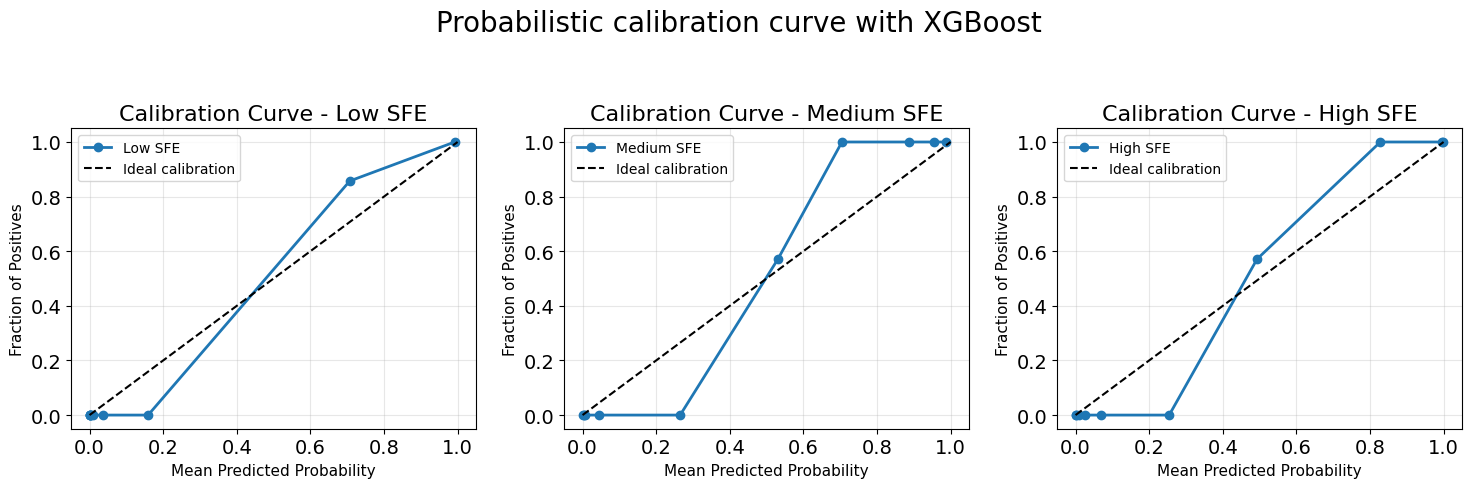

In [55]:
from sklearn.calibration import CalibratedClassifierCV
#Convert multi-class classification to binary classification format
y_test_bin_xgb=label_binarize(y_xgb_test_pred_1,classes=[1,2,3])


class_names=['Low SFE','Medium SFE','High SFE']
#Collect calibration curve data
prob_true_list_xgb=[]
prob_pred_list_xgb=[]

for i in range(3):
    #Get the true labels and predicted probabilities of the current category
    y_true_class_xgb=y_test_bin_xgb[:,i]
    y_prob_class_xgb=y_xgb_test_prob[:,i]
    #Ensure there are sufficient positive and negative samples
    if len(np.unique(y_true_class_xgb))>1:
        prob_true_xgb,prob_pred_xgb=calibration_curve(y_true_class_xgb,y_prob_class_xgb,n_bins=10,strategy='quantile')
        prob_true_list_xgb.append(prob_true_xgb)
        prob_pred_list_xgb.append(prob_pred_xgb)
        print(f"class{i+1}({class_names[i]}) - collected{len(prob_true_xgb)}points")
    else:
        print(f"Warning: Category{i+1}({class_names[i]})Insufficient samples, skipped")
        #Add an empty array to keep the indices consistent
        prob_true_list_xgb.append(np.array([]))
        prob_pred_list_xgb.append(np.array([]))
        print(f"prob_true_list_xgb length：{len(prob_true_list_xgb)}")
        print(f"prob_pred_list_xgb length：{len(prob_pred_list_xgb)}")

#Perform analysis
if len(prob_true_list_xgb)>=3:
    analyze_calibration_curves(prob_true_list_xgb,prob_pred_list_xgb,class_names)
    for i in range(3):
        if len(prob_true_list_xgb[i])>0:
            identify_calibration_patterns(prob_true_list_xgb[i],prob_pred_list_xgb[i],class_names[i])
        else:
            print(f"skip class{class_names[i]} - No data")
    metrics=quantitative_calibration_analysis(y_test_bin_xgb,y_xgb_test_prob,class_names)
    detailed_calibration_visualization_xgb(y_test_bin_xgb,y_xgb_test_prob,class_names)
else:
    print("Error: Insufficient calibration curve data")

feature_name_xgb:['C', 'N', 'Ni', 'Al', 'Fe', 'Mo', 'Mn', 'Si', 'Cr']
===== Feature Importance (including variance) =====
  feature  importance_mean  importance_std  importance_var
0      Ni         0.107111        0.036512        0.001333
1      Fe         0.061333        0.027883        0.000777
2       C         0.052000        0.023938        0.000573
3      Mo         0.033333        0.020584        0.000424
4       N         0.015111        0.026158        0.000684
5      Mn         0.013333        0.020656        0.000427
6      Si         0.010222        0.022227        0.000494
7      Cr         0.008889        0.022133        0.000490
8      Al        -0.012889        0.007289        0.000053


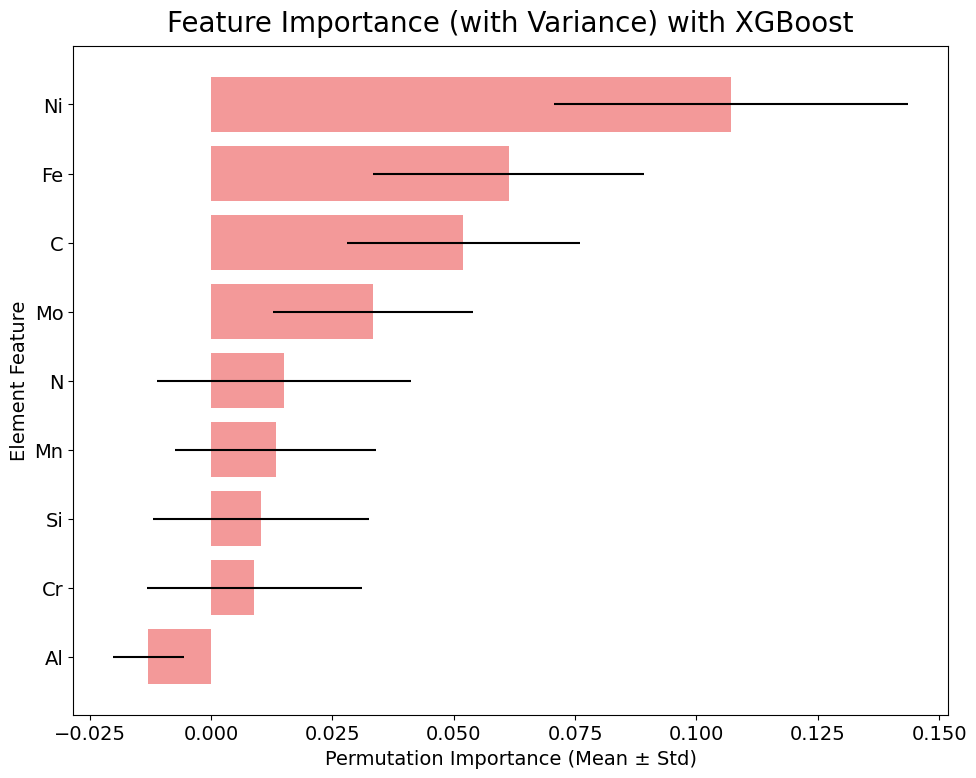

In [56]:
# Feature name (corresponding to the columns of NormElements: C, N, Ni, Al, Fe, Mo, Mn, Si, Cr)
feature_names_xgb = ini_dataset_5.columns.values[0:9].tolist()  #Get feature names from ini_dataset_5
print(f"feature_name_xgb:{feature_names_xgb}")
# Call the function (calculate using the test set X_test to avoid overfitting)
importance_result_xgb = get_permutation_importance_variance(
    model=best_xgb,
    X=X_test,  # Evaluate using an independent test set
    y=y_test_xgb,
    feature_names=feature_names_xgb,
    n_repeats=30,  # Evaluate using an independent test set
    task_type="classification",  # Classification task
    scoring="accuracy",  # Evaluation metrics for classification tasks
    return_df=True  # Return DataFrame format
)


# ========== output result ==========
print("===== Feature Importance (including variance) =====")
print(importance_result_xgb)


# ========== 4. Visualization  ==========
import matplotlib.pyplot as plt

def plot_importance_with_variance(importance_df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 8))
    plt.barh(
        importance_df["feature"],
        importance_df["importance_mean"],
        xerr=importance_df["importance_std"],  # Error bars = standard deviation (reflecting variance)
        color="lightcoral",
        alpha=0.8
    )
    plt.xlabel("Permutation Importance (Mean ± Std)")
    plt.ylabel("Element Feature")
    plt.title(title,fontsize=20,y=1.01)
    plt.gca().invert_yaxis()  # Sort in descending order from top to bottom
    plt.tight_layout()
    plt.savefig("Feature Importance (with Variance) with XGBoost.tiff",format='tiff',dpi=600,bbox_inches='tight')
    plt.show()

# Plot feature importance (including variance)
plot_importance_with_variance(
    importance_result_xgb,
    "Feature Importance (with Variance) with XGBoost"
)

In [57]:
#Obtain the prediction probabilities and uncertainties of the validation set
print("\nCalculate the predicted probability and uncertainty...")
#Get the prediction probabilities of all trees
tree_probabilities_xgb = []
# Get the total number of trees
n_trees_xgb = best_xgb.n_estimators

# Traverse each tree (from the first to the last)
for tree_idx in range(1, n_trees_xgb + 1):
    # Use iteration_range to specify that only the first tree_idx trees are used for prediction
    # predict_proba directly outputs a probability matrix of (number of samples, number of classes)
    tree_probs_xgb = best_xgb.predict_proba(
        X_test,
        iteration_range=(0, tree_idx)  # Key: Limit the scope of trees used
    )
    tree_probabilities_xgb.append(tree_probs_xgb)

# Verification result: Output the shape of the prediction probability of the first tree
print(f"Shape of prediction probability of a single tree：{tree_probabilities_xgb[0].shape}")  # should be(n_samples, n_classes)
    
#shape:(n_estimators,n_samples,n_classes)
#Calculate the average probability
y_pred_proba_xgb=np.mean(tree_probabilities_xgb,axis=0)
#Predicted category
y_pred_xgb=np.argmax(y_pred_proba_xgb,axis=1)+1
#Calculate the uncertainty of the prediction
#Method 1: Standard deviation of predicted probabilities (calculated separately by category)
prob_std_xgb=np.std(tree_probabilities_xgb,axis=0)
#The standard deviation of the probability for each category of each sample
#Method 2: Confidence (Maximum Probability)
confidence_xgb=np.max(y_pred_proba_xgb,axis=1)
#Method 3: Uncertainty Index (1 - Maximum Probability)
uncertainty_xgb=1-confidence_xgb
#Method 4: Entropy (a measure of uncertainty in information theory)
entropy_xgb=-np.sum(y_pred_proba_xgb*np.log(y_pred_proba_xgb+1e-10),axis=1)
#Method 5: Quantile of the prediction interval (for the maximum probability category)
alpha=0.05#95% confidence interval
pre_class_indices_xgb=y_pred_xgb-1
prob_intervals_xgb=[]
tree_sample_num_xgb = len(tree_probabilities_xgb[0])
# Change the loop range to tree_sample_num
for i in range(tree_sample_num_xgb):
    #Get all tree prediction probabilities for the predicted category
    class_prob_samples_xgb = [
    tree_probs_xgb[i][pre_class_indices_xgb[i]]  # Each tree → the i-th sample → the probability corresponding to the predicted category
    for tree_probs_xgb in tree_probabilities_xgb]
   
#Calculate quantile intervals
    lower_bound_xgb=np.percentile(class_prob_samples_xgb,(alpha/2)*100)
    upper_bound_xgb=np.percentile(class_prob_samples_xgb,(1-alpha/2)*100)
    mean_prob_xgb=np.mean(class_prob_samples_xgb)
    prob_intervals_xgb.append({'pred_class_xgb':pre_class_indices_xgb[i],'mean_prob_xgb':mean_prob_xgb,'lower_bound_xgb':lower_bound_xgb,'upper_bound_xgb':upper_bound_xgb,
    'interval_width_xgb':upper_bound_xgb-lower_bound_xgb})
    prob_intervals_df_xgb=pd.DataFrame(prob_intervals_xgb)
#5.Output prediction uncertainty and interval information
print("\n"+"="*60)
print("Uncertainty of prediction on the test set and confidence interval")
print("="*60)
#Create a DataFrame containing prediction information
results_df_xgb=pd.DataFrame({'true class':y_test,'prediction class':y_pred_xgb,'right prediction':y_test==y_pred_xgb,'confidence':confidence_xgb,'uncertainty':uncertainty_xgb,'entropy':entropy_xgb,
'Maximum probability category':np.argmax(y_pred_proba_xgb,axis=1),'Maximum probability':np.max(y_pred_proba_xgb,axis=1)})
#Add the prediction probabilities of various categories
for i in range(best_xgb.n_classes_):
    results_df_xgb[f'class{i}_probability']=y_pred_proba_xgb[:,i]
    results_df_xgb[f'class{i}_Probability standard deviation']=prob_std_xgb[:,i]
print(f"\nPrediction uncertainty and confidence intervals for the first 10 samples({100*(1-alpha)}%confidence level：)")
sample_info_xgb=pd.DataFrame({'true class':y_test[:10],'prediction class':y_pred_xgb[:10],'right prediction':results_df_xgb['right prediction'][:10],'confidence':confidence_xgb[:10].round(4),
'uncertainty':uncertainty_xgb[:10].round(4),'Maximum probability':results_df_xgb['Maximum probability'][:10].round(4),'lower bound':prob_intervals_df_xgb['lower_bound_xgb'][:10].round(4),
'upper bound':prob_intervals_df_xgb['upper_bound_xgb'][:10].round(4),'interval width':prob_intervals_df_xgb['interval_width_xgb'][:10].round(4)})
print(sample_info_xgb)
#print(prob_intervals[:5])
print(f"\nStatistical Summary of Uncertainty and Confidence Intervals：")
print(f"Average confidence level：{confidence_xgb.mean():.4f}")
print(f"Confidence standard deviation：{confidence_xgb.std():.4f}")
print(f"Average uncertainty：{uncertainty_xgb.mean():.4f}")
print(f"Average entropy：{entropy_xgb.mean():.4f}")
print(f"Average probability interval width：{prob_intervals_df_xgb['interval_width_xgb'].mean():4f}")

#Statistical grouping by prediction accuracy
print(f"\nUncertainty statistics grouped by prediction accuracy：")
correct_stats_xgb=results_df_xgb.groupby('right prediction').agg({'confidence':['mean','std','min','max'],'uncertainty':['mean','std'],'entropy':['mean','std']}).round(4)
print(correct_stats_xgb)


Calculate the predicted probability and uncertainty...
Shape of prediction probability of a single tree：(75, 3)

Uncertainty of prediction on the test set and confidence interval

Prediction uncertainty and confidence intervals for the first 10 samples(95.0%confidence level：)
   true class  prediction class  right prediction  confidence  uncertainty  \
0         1.0                 1              True      0.9517       0.0483   
1         1.0                 2             False      0.8242       0.1758   
2         3.0                 3              True      0.7906       0.2094   
3         3.0                 3              True      0.8913       0.1087   
4         1.0                 1              True      0.9367       0.0633   
5         2.0                 2              True      0.6391       0.3609   
6         3.0                 3              True      0.9571       0.0429   
7         1.0                 1              True      0.9449       0.0551   
8         3.0       

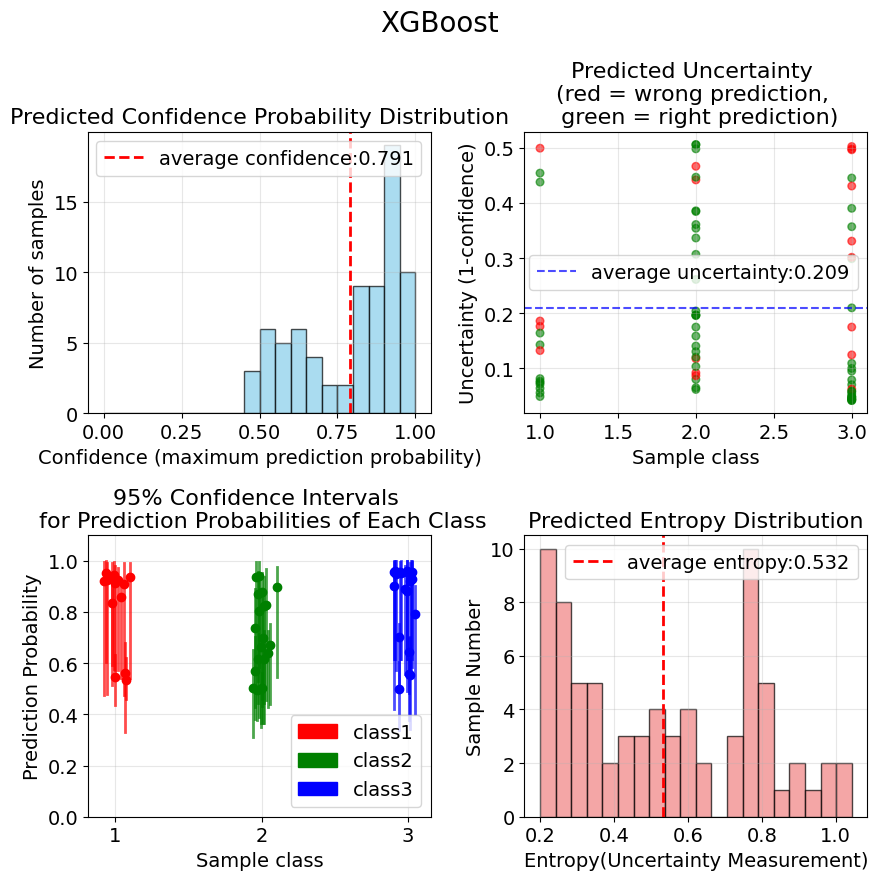

In [58]:
from matplotlib.patches import Patch
#Visualizing prediction uncertainty and confidence intervals
fig,axes=plt.subplots(2,2,figsize=(9,9))
fig.suptitle('XGBoost',fontsize=20,y=0.98)
#Subgraph 1: Confidence Distribution
bins=np.linspace(0,1,21)
axes[0,0].hist(confidence_xgb,bins=bins,alpha=0.7,color='skyblue',edgecolor='black')
axes[0,0].axvline(confidence_xgb.mean(),color='red',linestyle='--',linewidth=2,label=f'average confidence:{confidence_xgb.mean():.3f}')
axes[0,0].set_xlabel('Confidence (maximum prediction probability)')
axes[0,0].set_ylabel('Number of samples')
axes[0,0].set_title('Predicted Confidence Probability Distribution')
axes[0,0].legend()
axes[0,0].grid(True,alpha=0.3)
#Subgraph 2: The Relationship between Uncertainty and Prediction Accuracy
correct_colors=['red'if not c else 'green' for c in results_df_xgb['right prediction']]
axes[0,1].scatter(results_df_xgb['true class'],uncertainty_xgb,c=correct_colors,alpha=0.6,s=30)
axes[0,1].axhline(uncertainty_xgb.mean(),color='blue',linestyle='--',alpha=0.7,label=f'average uncertainty:{uncertainty_xgb.mean():.3f}')
axes[0,1].set_xlabel('Sample class')
axes[0,1].set_ylabel('Uncertainty (1-confidence)')
axes[0,1].set_title('Predicted Uncertainty \n(red = wrong prediction, \n green = right prediction)')
axes[0,1].legend()
axes[0,1].grid(True,alpha=0.3)
#Subgraph 3: Prediction Probability Intervals for Various Categories
class_colors=['red','green','blue']
# Define the categories corresponding to the abscissa (1, 2, 3)
class_x_pos = {1: 1, 2: 2, 3: 3}  # Category → Abscissa position
for class_idx in range(best_xgb.n_classes_):
    #Select the samples predicted to be in this category
    current_class_xgb = class_idx + 1  # True categories (1, 2, 3)
    class_mask_xgb = results_df_xgb['prediction class'] == current_class_xgb
    if np.sum(class_mask_xgb)>0:
        class_indices_xgb=np.where(class_mask_xgb)[0][:min(20,np.sum(class_mask_xgb))]#Display a maximum of 20
        # Add slight jitter to samples of the same category (to avoid overlap)
        jitter = np.random.normal(0, 0.05, size=len(class_indices_xgb))  # Small-range random jitter
        x_pos = class_x_pos[current_class_xgb] + jitter  # Category corresponds to the abscissa + jitter
        for i, idx in enumerate(class_indices_xgb):
            interval_xgb=prob_intervals_df_xgb.iloc[idx]
            axes[1,0].plot([x_pos[i], x_pos[i]],[interval_xgb['lower_bound_xgb'],interval_xgb['upper_bound_xgb']],color=class_colors[class_idx],alpha=0.7,linewidth=2)
            axes[1,0].plot(x_pos[i],interval_xgb['mean_prob_xgb'],'o',color=class_colors[class_idx],markersize=6)
axes[1,0].set_xticks([1, 2, 3])
axes[1,0].set_xlabel('Sample class')  # Modify the X-axis label
axes[1,0].set_ylabel('Prediction Probability')
axes[1,0].set_title('95% Confidence Intervals \n for Prediction Probabilities of Each Class')
legend_elements = [
    Patch(facecolor='red', edgecolor='red', label='class1'),  # class1 Corresponds to red
    Patch(facecolor='green', edgecolor='green', label='class2'),  # class2 Corresponds to green
    Patch(facecolor='blue', edgecolor='blue', label='class3')  # class3 Corresponds to blue
]
axes[1,0].legend(handles=legend_elements, loc='lower right')
axes[1,0].grid(True,alpha=0.3)
axes[1,0].set_ylim(0,1.1)
#Subgraph 4: Entropy Distribution
axes[1,1].hist(entropy_xgb,bins=20,alpha=0.7,color='lightcoral',edgecolor='black')
axes[1,1].axvline(entropy_xgb.mean(),color='red',linestyle='--',linewidth=2,label=f'average entropy:{entropy_xgb.mean():.3f}')
axes[1,1].set_xlabel('Entropy(Uncertainty Measurement)')
axes[1,1].set_ylabel('Sample Number')
axes[1,1].set_title('Predicted Entropy Distribution')
axes[1,1].legend()
axes[1,1].grid(True,alpha=0.3)

plt.tight_layout()
plt.show
plt.savefig("Prediction interval_XGBoost.tiff",format ='tiff', dpi=600, bbox_inches='tight',orientation='landscape')

Gradient boosting

In [59]:
from sklearn.ensemble import GradientBoostingClassifier
y_train_val_gb=y_train_val
y_test_gb=y_test
# Use imblearn's ImbPipeline which is compatible with SMOTE (the ordinary Pipeline does not support the sampling step)
pipeline_gb = ImbPipeline([
    ("smote", SMOTE(random_state=50, k_neighbors=5)),  # Step 1: SMOTE oversampling (only performed on the training set)
    ("gb", GradientBoostingClassifier(                 # Step 2: Gradient Boosting Tree Classifier
        loss='log_loss',  # For multi-class classification tasks, log_loss is used (corresponding to softmax), and for binary classification tasks, 'deviance' can be used.
        random_state=50
    ))
])
#Define the hyperparameter space
param_dist_gb_stage1 = {"gb__max_depth": [3, 5, 7],"gb__learning_rate": [0.05, 0.1, 0.2],"gb__n_estimators": [50, 100, 150],
                         "gb__subsample": [0.8, 1.0]}

# Define five-fold cross-validation (maintaining class distribution using StratifiedKFold)
skf_gb = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
random_search_gb = RandomizedSearchCV(
    pipeline_gb, param_dist_gb_stage1, n_iter=10, cv=skf_gb, scoring='accuracy', n_jobs=1, random_state=50)
# train
random_search_gb.fit(X_train_val, y_train_val_gb)
best_gb_params=random_search_gb.best_params_
print (random_search_gb.best_params_)
print(f"Gradient Boosting Optimal accuracy of cross-validation: {random_search_gb.best_score_:.4f}")
print(f"Gradient Boosting Cross-validation accuracy (mean ± standard deviation): {random_search_gb.cv_results_['mean_test_score'].mean():.4f} ± {random_search_gb.cv_results_['mean_test_score'].std():.4f}")
print(f"Gradient Boosting Cross-validation accuracy (each fold): {random_search_gb.cv_results_['mean_test_score']}")

{'gb__subsample': 0.8, 'gb__n_estimators': 100, 'gb__max_depth': 5, 'gb__learning_rate': 0.05}
Gradient Boosting Optimal accuracy of cross-validation: 0.7457
Gradient Boosting Cross-validation accuracy (mean ± standard deviation): 0.7331 ± 0.0096
Gradient Boosting Cross-validation accuracy (each fold): [0.73248588 0.70915254 0.72903955 0.74570621 0.74231638 0.72909605
 0.73909605 0.73915254 0.73242938 0.73242938]


In [60]:
#training the model
# ==========Train the final Gradient Boosting model==========
print("best_gb_params content：", best_gb_params)
# Step 1: Remove the "gb_" prefix from the parameter names
cleaned_params = {
    key.replace('gb__', ''): value  # Convert 'gb_subsample' to 'subsample', and so on.
    for key, value in best_gb_params.items()
}

best_gb = GradientBoostingClassifier(
    **cleaned_params,  # Import optimal parameters
    random_state=50,  # random seed
    verbose=0         # Do not output training logs
)

smote_gb = SMOTE(random_state=50, k_neighbors=5)  # k_neighbors is adjusted according to the sample size
X_train_val_smote_gb, y_train_val_smote_gb = smote_gb.fit_resample(X_train_val, y_train_val_gb)
print(f"Number of training set samples after SMOTE:{X_train_val_smote_gb.shape[0]} (original: {X_train_val.shape[0]})")
check_data_distribution(y_train_val_smote_gb)
best_gb.fit(X_train_val_smote_gb, y_train_val_smote_gb)


# ========== Model Evaluation ==========
# prediction
y_gb_train_pred = best_gb.predict(X_train_val)
y_gb_test_pred = best_gb.predict(X_test)
y_gb_test_prob = best_gb.predict_proba(X_test)  # Probability is used for calibration curves


#testing the model
from sklearn import metrics
model_score_gb = best_gb.score(X_test, y_test_gb)
print ("Model Score for Gradient Boosting on actual Data %.2f \n" % (model_score_gb))

train_score_gb = best_gb.score(X_train_val, y_train_val_gb)
print ("Model Score for Gradient Boosting on training Data %.2f \n" % (train_score_gb))
# accuracy
gb_train_acc = accuracy_score( y_train_val_gb, y_gb_train_pred)
gb_test_acc = accuracy_score(y_test_gb, y_gb_test_pred)
print(f"\nGradient Boosting train set accuracy: {gb_train_acc:.4f}")
print(f"Gradient Boosting test set accuracy: {gb_test_acc:.4f}")
# detailed report
print("\n=== Gradient Boosting Detailed Evaluation Report of the Test Set ===")
print(classification_report(y_test_gb, y_gb_test_pred))

best_gb_params content： {'gb__subsample': 0.8, 'gb__n_estimators': 100, 'gb__max_depth': 5, 'gb__learning_rate': 0.05}
Number of training set samples after SMOTE:369 (original: 299)
=== Category distribution ===
3.0    33.333333
2.0    33.333333
1.0    33.333333
Name: proportion, dtype: float64
Model Score for Gradient Boosting on actual Data 0.76 

Model Score for Gradient Boosting on training Data 0.97 


Gradient Boosting train set accuracy: 0.9666
Gradient Boosting test set accuracy: 0.7600

=== Gradient Boosting Detailed Evaluation Report of the Test Set ===
              precision    recall  f1-score   support

         1.0       0.80      0.80      0.80        15
         2.0       0.67      0.76      0.71        29
         3.0       0.85      0.74      0.79        31

    accuracy                           0.76        75
   macro avg       0.77      0.77      0.77        75
weighted avg       0.77      0.76      0.76        75



In [61]:

from sklearn.metrics import confusion_matrix
cm_gb = confusion_matrix(y_test_gb,y_gb_test_pred)
print ("Confusion Matrix \n", confusion_matrix(y_test_gb,y_gb_test_pred))

from sklearn.metrics import precision_score
print ("Precision scores across classes: ", precision_score(y_test_gb,y_gb_test_pred,average=None), "\n")

from sklearn.metrics import recall_score
print ("Recall scores across classes: ", recall_score(y_test_gb,y_gb_test_pred,average=None), "\n")

from sklearn.metrics import precision_score
print ("Macro Precision score: ",precision_score(y_test_gb,y_gb_test_pred,average='macro'), "\n")

from sklearn.metrics import recall_score
print ("Macro Recall score: ", recall_score(y_test_gb,y_gb_test_pred,average='macro'), "\n")

Confusion Matrix 
 [[12  3  0]
 [ 3 22  4]
 [ 0  8 23]]
Precision scores across classes:  [0.8        0.66666667 0.85185185] 

Recall scores across classes:  [0.8        0.75862069 0.74193548] 

Macro Precision score:  0.7728395061728396 

Macro Recall score:  0.7668520578420468 



In [62]:
#getting percentage values for confusion matrix
np.true_divide(cm_gb,75)*100

array([[16.        ,  4.        ,  0.        ],
       [ 4.        , 29.33333333,  5.33333333],
       [ 0.        , 10.66666667, 30.66666667]])

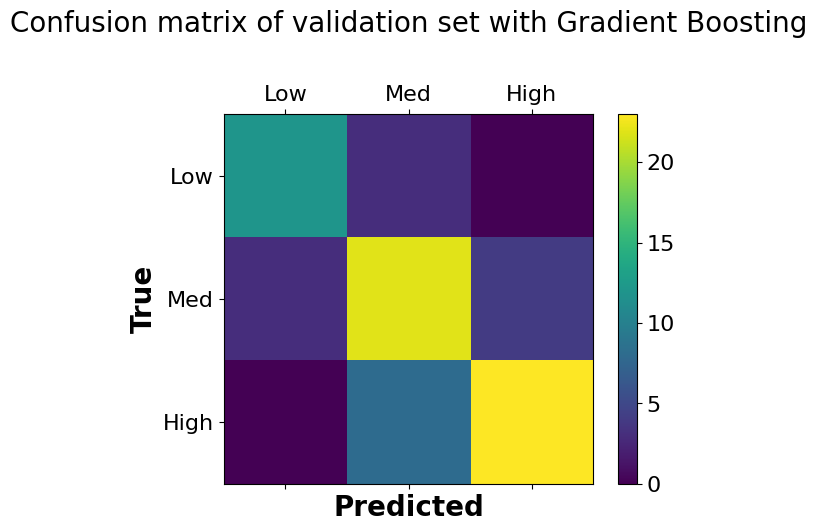

In [63]:
labels = ['Low', 'Med', 'High']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_gb, cmap=plt.get_cmap('viridis'))
ax.set_title('Confusion matrix of validation set with Gradient Boosting', fontsize=20, x=0.5, y=1.2)
cbar=fig.colorbar(cax)
cbar.ax.tick_params(labelsize=16)
ax.set_xticklabels([''] + labels,fontsize=16)
ax.set_yticklabels([''] + labels,fontsize=16)
plt.xlabel('Predicted', fontsize=20, fontweight = 'bold')
plt.ylabel('True', fontsize=20,  fontweight = 'bold')
plt.savefig("CM_Gradient Boosting.tiff",format ='tiff', dpi=600, bbox_inches='tight',orientation='landscape')
plt.show()

In [64]:
from sklearn.model_selection import StratifiedShuffleSplit
sss_gb=StratifiedShuffleSplit(n_splits=1,train_size=min(200,len(X_train_val)),random_state=42)
for train_index,_ in sss_gb.split(X_train_val,y_train_val_gb):
     background_gb=X_train_val[train_index]
     print(f"Background data shape：{background_gb.shape}")

Background data shape：(200, 9)


Gradient Boosting SHAP value

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/75 [00:00<?, ?it/s]

SHAP value type：<class 'shap._explanation.Explanation'>
Multi-class classification，have3class


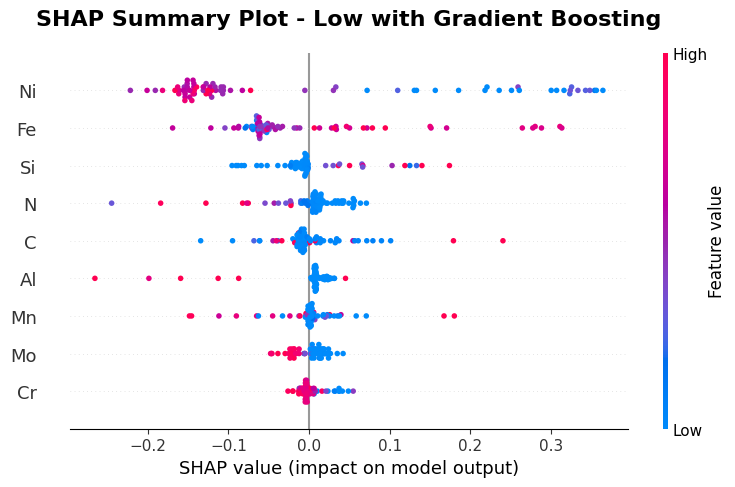

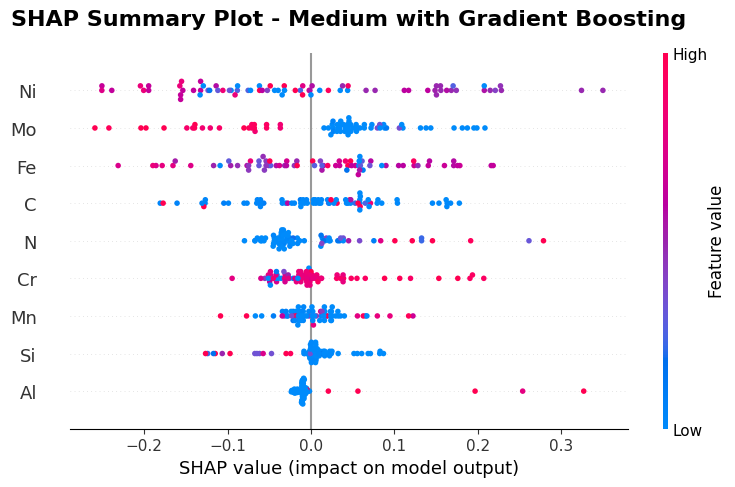

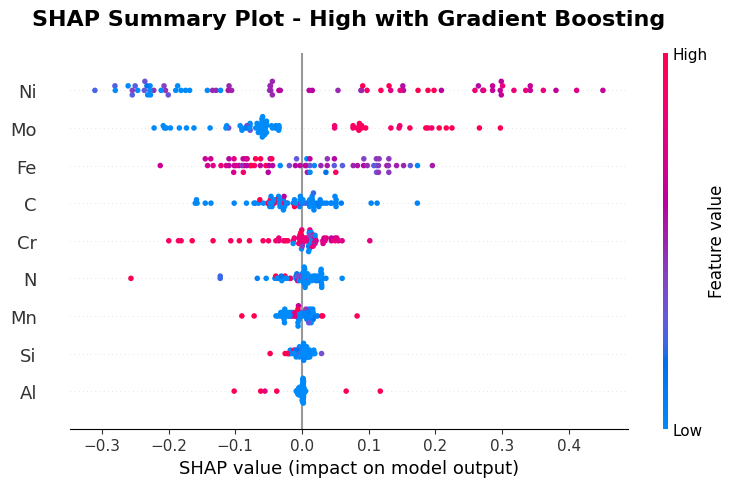

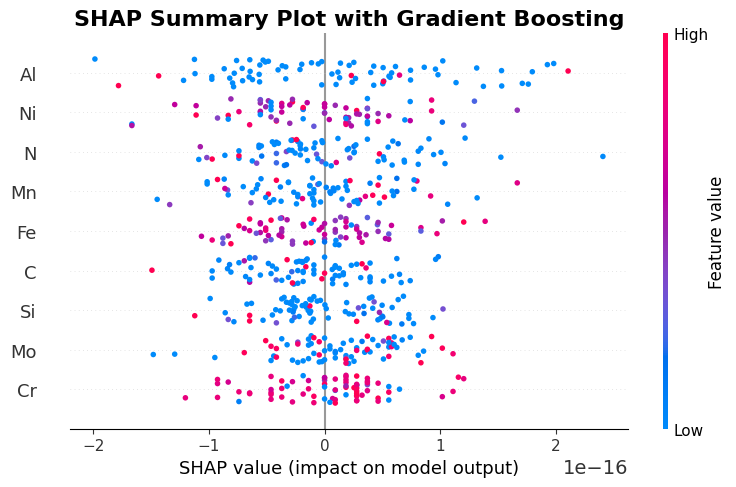

In [65]:
#Set a research-level style
plt.style.use('default')#Use the default style to maintain consistency
plt.rcParams.update({'font.size':14,
                     
                     'mathtext.fontset':'stix','axes.labelsize':14,
                   'axes.titlesize':16,'xtick.labelsize':14,'ytick.labelsize':14,'legend.fontsize':14,'figure.titlesize':20})
# SHAP value calculation


#Extract the list of original feature names
feature_names_SHAP=['C','N','Ni','Al','Fe','Mo','Mn','Si','Cr']
feature_names_SHAP=list(feature_names_SHAP)
#Ensure that the number of feature names matches the number of feature dimensions
if len(feature_names_SHAP)!=X_train_val.shape[1]:
    feature_names_SHAP=[f'element_{i}'for i in range(X_train_val.shape[1])]
    print(f"Warning: The number of feature names does not match; default names are used.：{feature_names_SHAP}")

explainer_gb = shap.KernelExplainer(
    model=best_gb.predict_proba,  # A function that passes in prediction probabilities
    data=background_gb
)
shap_values_gb = explainer_gb(X_test[:200])
print(f"SHAP value type：{type(shap_values_gb)}")

class_names_list=["Low","Medium","High"]
if len(shap_values_gb.shape)==3:
    n_classes_gb=shap_values_gb.shape[2]
    print(f"Multi-class classification，have{n_classes_xgb}class")
    for class_idx_gb in range(n_classes_gb):
        
        plt.figure(figsize=(10,8))
        
        class_shap_gb=shap_values_gb[:,:,class_idx_gb]
        shap.summary_plot(
            class_shap_gb,
            features=X_test[:200],
            feature_names=feature_names_SHAP,
            plot_type="dot",
            show=False,
            
        )
        if class_idx_gb< len(class_names_list):
            class_name=class_names_list[class_idx_gb]
        else:
            class_name=f"Class {class_idx_gb}"
        plt.title(f"SHAP Summary Plot - {class_name} with Gradient Boosting",fontsize=16,fontweight='bold',pad=20)
        plt.tight_layout()
        plt.savefig(f"SHAP Summary Plot - {class_name}_Gradient Boosting.tiff",format='tiff',dpi=600,bbox_inches='tight')
        plt.show()
    gb_mean_importance=shap_values_gb.mean(axis=2)
    plt.figure(figsize=(10,8))
    shap.summary_plot(gb_mean_importance,features=X_test[:200],feature_names=feature_names_SHAP,show=False,max_display=len(feature_names_SHAP))
    plt.title(f"SHAP Summary Plot with Gradient Boosting",fontsize=16,fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"SHAP Summary Plot _Gradient Boosting.tiff",format='tiff',dpi=600,bbox_inches='tight')
    plt.show()
elif len(shap_values_gb.shape)==2:
    print(f"Binary classification, SHAP value shape：{shap_values_gb.shape}")
else:
    print(f"Unknown format.shape：{shap_values_gb.shape}")

In [66]:
def detailed_calibration_visualization_gb(y_true_bin,y_prob,class_names):
    """
    Detailed calibration visualization analysis
    """
    fig, axes=plt.subplots(1,3,figsize=(15,5))
    axes=axes.ravel()
    fig.suptitle('Probabilistic calibration curve with Gradient Boosting',fontsize=20,y=0.98)
    class_names=['Low SFE','Medium SFE','High SFE']
    for i in range(3):
        #Get the true labels and predicted probabilities of the current category
        y_true_class=y_true_bin[:,i]
        y_prob_class=y_prob[:,i]
        prob_true,prob_pred=calibration_curve(y_true_class,y_prob_class,n_bins=10,strategy='quantile')
        #plot a curve
        
        axes[i].plot(prob_pred,prob_true,'o-',label=class_names[i],markersize=6,linewidth=2)
        
        axes[i].plot([0,1],[0,1],'k--',label='Ideal calibration',linewidth=1.5)
        
        axes[i].set_xlabel('Mean Predicted Probability',fontsize=11)
        
        axes[i].set_ylabel('Fraction of Positives',fontsize=11)
        
        axes[i].set_title(f'Calibration Curve - {class_names[i]}')
        
        axes[i].legend(loc='best',fontsize=10)
        
        axes[i].grid(True,alpha=0.3)
        
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.savefig("Probabilistic calbration curve_Gradient Boosting.tiff",format='tiff',dpi=600,bbox_inches='tight')
    plt.show()

class1(Low SFE) - collected10points
class2(Medium SFE) - collected10points
class3(High SFE) - collected10points
=== Probability calibration curve analysis===

---Low SFE analysis---
Mean absolute variance：0.0661
Points higher than the diagonal：2/10
Points below the diagonal：8/10
Calibration quality：Good calibration

---Medium SFE analysis---
Mean absolute variance：0.1234
Points higher than the diagonal：4/10
Points below the diagonal：6/10
Calibration quality：General calibration

---High SFE analysis---
Mean absolute variance：0.0770
Points higher than the diagonal：4/10
Points below the diagonal：6/10
Calibration quality：Good calibration

【Low SFEPattern Analysis】
Mode: Good Calibration
- The predicted probability is basically consistent with the actual probability
    regression slope：1.143305,intercept：-0.048

【Medium SFEPattern Analysis】
Pattern: Overconfidence - Model too deterministic定
- High probability overestimated, low probability underestimated
- Suggestion: Increase regularizati

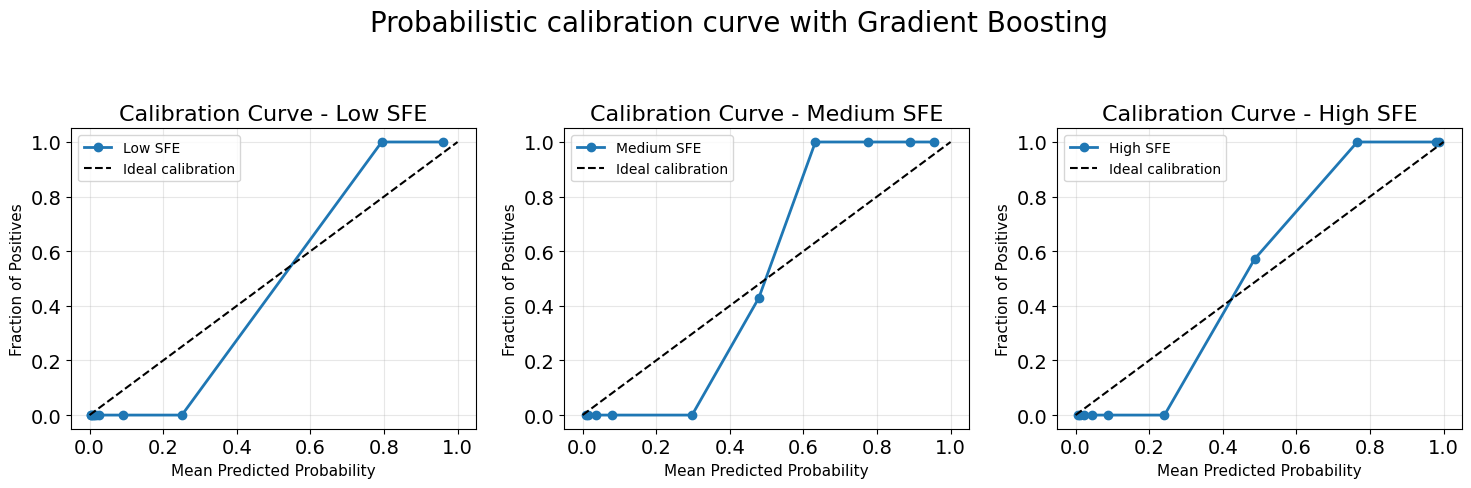

In [67]:
from sklearn.calibration import CalibratedClassifierCV
#Convert multi-class classification to binary classification format
y_test_bin_gb=label_binarize(y_gb_test_pred,classes=[1,2,3])

class_names=['Low SFE','Medium SFE','High SFE']
#Collect calibration curve data
prob_true_list_gb=[]
prob_pred_list_gb=[]

for i in range(3):
    #Get the true labels and prediction probabilities of the current category
    y_true_class_gb=y_test_bin_gb[:,i]
    y_prob_class_gb=y_gb_test_prob[:,i]
    #Ensure there are sufficient positive and negative samples
    if len(np.unique(y_true_class_gb))>1:
        prob_true_gb,prob_pred_gb=calibration_curve(y_true_class_gb,y_prob_class_gb,n_bins=10,strategy='quantile')
        prob_true_list_gb.append(prob_true_gb)
        prob_pred_list_gb.append(prob_pred_gb)
        print(f"class{i+1}({class_names[i]}) - collected{len(prob_true_gb)}points")
    else:
        print(f"Warning:class{i+1}({class_names[i]})Insufficient samples, skip")
        #Add an empty array to keep the indices consistent
        prob_true_list_gb.append(np.array([]))
        prob_pred_list_gb.append(np.array([]))
        print(f"prob_true_list_gb length：{len(prob_true_list_gb)}")
        print(f"prob_pred_list_gb length：{len(prob_pred_list_gb)}")

#perform analysis
if len(prob_true_list_gb)>=3:
    analyze_calibration_curves(prob_true_list_gb,prob_pred_list_gb,class_names)
    for i in range(3):
        if len(prob_true_list_gb[i])>0:
            identify_calibration_patterns(prob_true_list_gb[i],prob_pred_list_gb[i],class_names[i])
        else:
            print(f"skip class{class_names[i]} - no data")
    metrics=quantitative_calibration_analysis(y_test_bin_gb,y_gb_test_prob,class_names)
    detailed_calibration_visualization_gb(y_test_bin_gb,y_gb_test_prob,class_names)
else:
    print("Error: Insufficient calibration curve data")

feature_name_gb:['C', 'N', 'Ni', 'Al', 'Fe', 'Mo', 'Mn', 'Si', 'Cr']
===== Feature Importance (including variance) =====
  feature  importance_mean  importance_std  importance_var
0      Ni         0.132444        0.036096        0.001303
1      Fe         0.096444        0.032964        0.001087
2      Mo         0.078222        0.024762        0.000613
3       C         0.075556        0.023934        0.000573
4      Mn         0.047111        0.018772        0.000352
5      Si         0.041778        0.020289        0.000412
6       N         0.027556        0.019757        0.000390
7      Cr         0.023556        0.020851        0.000435
8      Al         0.012889        0.010027        0.000101


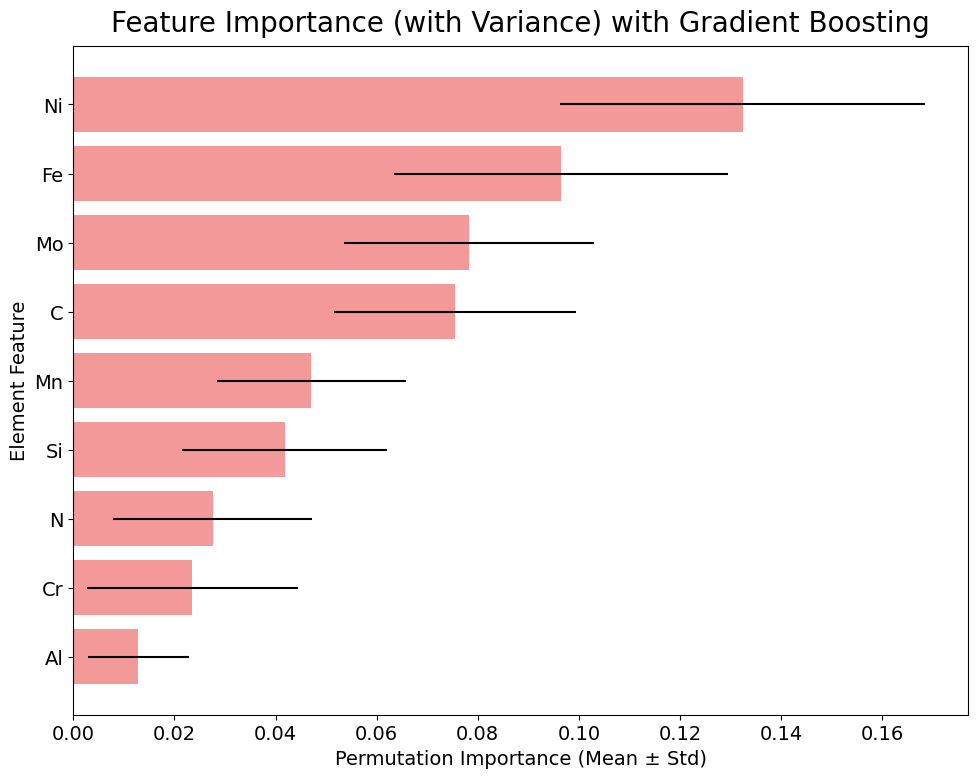

In [68]:
feature_names_gb = ini_dataset_5.columns.values[0:9].tolist()  # Get feature names from ini_dataset_5
print(f"feature_name_gb:{feature_names_gb}")
# Call the function (calculate using the test set X_test to avoid overfitting)
importance_result_gb = get_permutation_importance_variance(
    model=best_gb,
    X=X_test,  # Evaluate with an independent test set
    y=y_test_gb,
    feature_names=feature_names_gb,
    n_repeats=30,  # Number of permutation repetitions
    task_type="classification",  # Classification task
    scoring="accuracy",  # Evaluation metrics for classification tasks
    return_df=True  # Return DataFrame format
)


# ========== output result ==========
print("===== Feature Importance (including variance) =====")
print(importance_result_gb)


# ========== Visualization ==========
import matplotlib.pyplot as plt

def plot_importance_with_variance(importance_df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 8))
    plt.barh(
        importance_df["feature"],
        importance_df["importance_mean"],
        xerr=importance_df["importance_std"],  # Error bars = standard deviation (reflecting variance)
        color="lightcoral",
        alpha=0.8
    )
    plt.xlabel("Permutation Importance (Mean ± Std)")
    plt.ylabel("Element Feature")
    plt.title(title,fontsize=20,y=1.01)
    plt.gca().invert_yaxis()  # Arrange in descending order from top to bottom
    plt.tight_layout()
    plt.savefig(f"Feature Importance (with Variance) with Gradient Boosting.tiff",format='tiff',dpi=600,bbox_inches='tight')
    plt.show()
# Plot feature importance (including variance)
plot_importance_with_variance(
    importance_result_gb,
    "Feature Importance (with Variance) with Gradient Boosting"
)

In [69]:
#Obtain the predicted probabilities and uncertainties of the validation set
print("\nCalculate prediction probabilities and uncertainties...")
def get_tree_probs_gb(model, X, tree_idx):
    """
    Extract the predicted probabilities of the first tree_idx trees in the GradientBoosting model
    :param model: Trained GradientBoostingClassifier (multi-class classification)
    :param X: Input feature data
    :param tree_idx: The first tree_idx trees to be used (1 <= tree_idx <= n_estimators)
    :return: A probability matrix of (number of samples, number of categories)
    """
    # Boundary handling: tree_idx cannot exceed the number of trees in the model
    tree_idx = min(tree_idx, model.n_estimators)
    
    # The estimators_ of GradientBoosting is an array of [number of categories × number of trees] (each category corresponds to a set of regression trees).
    n_classes = model.n_classes_
    tree_scores = np.zeros((X.shape[0], n_classes))  # Initialize the score matrix
    
    # Iterate through each category and accumulate the prediction scores of the first tree_idx trees
    for class_idx in range(n_classes):
        # Take the first tree_idx trees in the current category
        class_trees = model.estimators_[class_idx][:tree_idx]
        # Sum the predicted scores of each tree (each individual tree is a regression prediction, outputting a continuous value)
        for tree in class_trees:
            tree_scores[:, class_idx] += tree.predict(X)
    
    # Convert scores to probabilities (softmax normalization, multi-class classification scenario)
    exp_scores = np.exp(tree_scores)
    tree_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return tree_probs
#Get the predicted probabilities of all trees
tree_probabilities_gb = []
# Get the total number of trees
n_trees_gb = best_gb.n_estimators  # Total number of trees in the model

# Iterate through each tree and store the predicted probabilities of the first i trees.
for i in range(1, n_trees_gb + 1):
    tree_probs_gb = get_tree_probs_gb(best_gb, X_test, i)
    tree_probabilities_gb.append(tree_probs_gb)
    
# Verification result: Output the shape of the prediction probability of the first tree
print(f"Shape of prediction probability of a single tree：{tree_probabilities_gb[0].shape}")  # should be(n_samples, n_classes)
    
#Calculate the average probability
y_pred_proba_gb=np.mean(tree_probabilities_gb,axis=0)
#Predicted category
y_pred_gb=np.argmax(y_pred_proba_gb,axis=1)+1
#Calculate the uncertainty of the prediction
#Method 1: Standard deviation of predicted probabilities (calculated separately for each category)
prob_std_gb=np.std(tree_probabilities_gb,axis=0)
#The standard deviation of probabilities for each category of each sample
#Method 2: Confidence (Maximum Probability)
confidence_gb=np.max(y_pred_proba_gb,axis=1)
#Method 3: Uncertainty Index (1 - Maximum Probability)
uncertainty_gb=1-confidence_gb
#Method 4: Entropy (a measure of uncertainty in information theory)
entropy_gb=-np.sum(y_pred_proba_gb*np.log(y_pred_proba_gb+1e-10),axis=1)
#Method 5: Quantile of the prediction interval (for the maximum probability category)
alpha=0.05
#For each sample's maximum probability category, calculate the confidence interval of the probability.
pre_class_indices_gb=y_pred_gb-1
prob_intervals_gb=[]

tree_sample_num_gb = len(tree_probabilities_gb[0])
# Change the loop range to tree_sample_num
for i in range(tree_sample_num_gb):
    #Get all tree prediction probabilities for the predicted category
    class_prob_samples_gb = [
    tree_probs[i][pre_class_indices_gb[i]]  # Each tree → the i-th sample → the probability corresponding to the predicted category
    for tree_probs in tree_probabilities_gb]
    
#Calculate quantile intervals
    lower_bound_gb=np.percentile(class_prob_samples_gb,(alpha/2)*100)
    upper_bound_gb=np.percentile(class_prob_samples_gb,(1-alpha/2)*100)
    mean_prob_gb=np.mean(class_prob_samples_gb)
    prob_intervals_gb.append({'pred_class_gb':pre_class_indices_gb[i],'mean_prob_gb':mean_prob_gb,'lower_bound_gb':lower_bound_gb,'upper_bound_gb':upper_bound_gb,
    'interval_width_gb':upper_bound_gb-lower_bound_gb})
    prob_intervals_df_gb=pd.DataFrame(prob_intervals_gb)
#5.Output prediction uncertainty and interval information
print("\n"+"="*60)
print("Test set prediction uncertainty and confidence intervals")
print("="*60)
#Create a DataFrame containing prediction information
results_df_gb=pd.DataFrame({'true class':y_test,'prediction class':y_pred_gb,'right prediction':y_test==y_pred_gb,'confidence':confidence_gb,'uncertainty':uncertainty_gb,'entropy':entropy_gb,
'Maximum probability category':np.argmax(y_pred_proba_gb,axis=1),'maximum probability':np.max(y_pred_proba_gb,axis=1)})
#Add the prediction probabilities of various categories
for i in range(best_gb.n_classes_):
    results_df_gb[f'class{i}_probabilities']=y_pred_proba_gb[:,i]
    results_df_gb[f'class{i}_Probability standard deviation']=prob_std_gb[:,i]
print(f"\nPrediction uncertainty and confidence intervals for the first 10 samples({100*(1-alpha)}%Confidence level：)")
sample_info_gb=pd.DataFrame({'true class':y_test[:10],'prediction class':y_pred_gb[:10],'right prediction':results_df_gb['right prediction'][:10],'confidence':confidence_gb[:10].round(4),
'uncertainty':uncertainty_gb[:10].round(4),'maximum probability':results_df_gb['maximum probability'][:10].round(4),'lower bound':prob_intervals_df_gb['lower_bound_gb'][:10].round(4),
'upper bound':prob_intervals_df_gb['upper_bound_gb'][:10].round(4),'interval width':prob_intervals_df_gb['interval_width_gb'][:10].round(4)})
print(sample_info_gb)

print(f"\nStatistical Summary of Uncertainty and Confidence Intervals：")
print(f"Average confidence level：{confidence_gb.mean():.4f}")
print(f"Standard deviation of confidence level：{confidence_gb.std():.4f}")
print(f"Average uncertainty：{uncertainty_gb.mean():.4f}")
print(f"Average entropy：{entropy_gb.mean():.4f}")
print(f"Average probability interval width：{prob_intervals_df_gb['interval_width_gb'].mean():4f}")

#Statistical grouping by prediction accuracy
print(f"\nStatistics of uncertainty grouped by prediction accuracy：")
correct_stats_gb=results_df_gb.groupby('right prediction').agg({'confidence':['mean','std','min','max'],'uncertainty':['mean','std'],'entropy':['mean','std']}).round(4)
print(correct_stats_gb)


Calculate prediction probabilities and uncertainties...
Shape of prediction probability of a single tree：(75, 3)

Test set prediction uncertainty and confidence intervals

Prediction uncertainty and confidence intervals for the first 10 samples(95.0%Confidence level：)
   true class  prediction class  right prediction  confidence  uncertainty  \
0         1.0                 2             False      0.6858       0.3142   
1         1.0                 2             False      0.6437       0.3563   
2         3.0                 3              True      0.8791       0.1209   
3         3.0                 2             False      0.5299       0.4701   
4         1.0                 1              True      0.4691       0.5309   
5         2.0                 1             False      0.8845       0.1155   
6         3.0                 2             False      0.3967       0.6033   
7         1.0                 1              True      0.3580       0.6420   
8         3.0               

In [70]:
tree_sample_num_gb = len(tree_probabilities_gb[0])
for i in range(tree_sample_num_gb):
    class_prob_samples_gb = [
        tree_probs[i][pre_class_indices_gb[i]]
        for tree_probs in tree_probabilities_gb
    ]
    print(f"sample{i} all tree probabilities ：{class_prob_samples_gb[:5]}")  # Print the probabilities of the first 5 trees

sample0 all tree probabilities ：[0.32785646209520125, 0.6878719892338977, 0.6894086554337114, 0.6894086554337114, 0.6894086554337114]
sample1 all tree probabilities ：[0.1101176385582808, 0.6559681789862286, 0.6489949205085117, 0.6489949205085117, 0.6489949205085117]
sample2 all tree probabilities ：[0.33334027201890426, 0.9071711402714402, 0.8844041120917754, 0.8844041120917754, 0.8844041120917754]
sample3 all tree probabilities ：[0.32649945385849355, 0.9051069220741083, 0.5281893305360462, 0.5281893305360462, 0.5281893305360462]
sample4 all tree probabilities ：[0.3999658766534745, 0.4885822881531815, 0.46957075668648923, 0.46957075668648923, 0.46957075668648923]
sample5 all tree probabilities ：[0.9077702459699871, 0.8906943203370916, 0.8841606321334232, 0.8841606321334232, 0.8841606321334232]
sample6 all tree probabilities ：[0.3269228841744979, 0.4043111951120422, 0.3973099360588371, 0.3973099360588371, 0.3973099360588371]
sample7 all tree probabilities ：[0.3550082144928607, 0.37297943

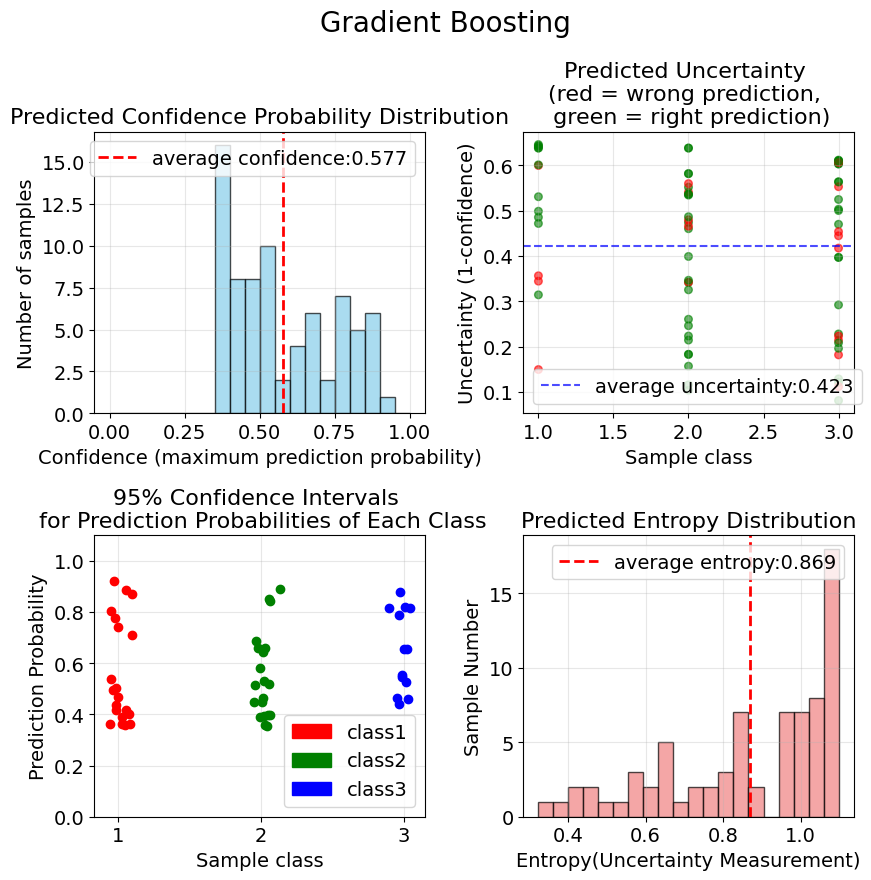

In [73]:
from matplotlib.patches import Patch
#Visualizing prediction uncertainty and confidence intervals
fig,axes=plt.subplots(2,2,figsize=(9,9))
fig.suptitle('Gradient Boosting',fontsize=20,y=0.98)
#Subgraph 1: Confidence Distribution
bins=np.linspace(0,1,21)
axes[0,0].hist(confidence_gb,bins=bins,alpha=0.7,color='skyblue',edgecolor='black')
axes[0,0].axvline(confidence_gb.mean(),color='red',linestyle='--',linewidth=2,label=f'average confidence:{confidence_gb.mean():.3f}')
axes[0,0].set_xlabel('Confidence (maximum prediction probability)')
axes[0,0].set_ylabel('Number of samples')
axes[0,0].set_title('Predicted Confidence Probability Distribution')
axes[0,0].legend()
axes[0,0].grid(True,alpha=0.3)
#Subgraph 2: Relationship between Uncertainty and Prediction Accuracy
correct_colors=['red'if not c else 'green' for c in results_df_xgb['right prediction']]
axes[0,1].scatter(results_df_gb['true class'],uncertainty_gb,c=correct_colors,alpha=0.6,s=30)
axes[0,1].axhline(uncertainty_gb.mean(),color='blue',linestyle='--',alpha=0.7,label=f'average uncertainty:{uncertainty_gb.mean():.3f}')
axes[0,1].set_xlabel('Sample class')
axes[0,1].set_ylabel('Uncertainty (1-confidence)')
axes[0,1].set_title('Predicted Uncertainty \n(red = wrong prediction, \n green = right prediction)')
axes[0,1].legend()
axes[0,1].grid(True,alpha=0.3)
#Subgraph 3: Prediction Probability Intervals for Each Category
class_colors=['red','green','blue']
# Define the categories corresponding to the abscissa (1, 2, 3)
class_x_pos = {1: 1, 2: 2, 3: 3}  # Category → Abscissa position
for class_idx in range(best_gb.n_classes_):
    #Select samples predicted to be in this category
    current_class_gb = class_idx + 1  # True categories (1, 2, 3)
    class_mask_gb = results_df_gb['prediction class'] == current_class_gb
    if np.sum(class_mask_gb)>0:
        class_indices_gb=np.where(class_mask_gb)[0][:min(20,np.sum(class_mask_gb))]#Display a maximum of 20
        # Add slight jitter to samples of the same category (to avoid overlap)
        jitter = np.random.normal(0, 0.05, size=len(class_indices_gb))  # Small-range random jitter
        x_pos = class_x_pos[current_class_gb] + jitter  # Category corresponding to the abscissa + jitter
        for i, idx in enumerate(class_indices_gb):
            interval_gb=prob_intervals_df_gb.iloc[idx]
            axes[1,0].plot([x_pos[i], x_pos[i]],[interval_gb['lower_bound_gb'],interval_gb['upper_bound_gb']],color=class_colors[class_idx],alpha=0.7,linewidth=2)
            axes[1,0].plot(x_pos[i],interval_gb['mean_prob_gb'],'o',color=class_colors[class_idx],markersize=6)
axes[1,0].set_xticks([1, 2, 3])
axes[1,0].set_xlabel('Sample class')  # Modify the X-axis label
axes[1,0].set_ylabel('Prediction Probability')
axes[1,0].set_title('95% Confidence Intervals \n for Prediction Probabilities of Each Class')
legend_elements = [
    Patch(facecolor='red', edgecolor='red', label='class1'),  # class1 corresponding to red
    Patch(facecolor='green', edgecolor='green', label='class2'),  # class2 corresponding to green
    Patch(facecolor='blue', edgecolor='blue', label='class3')  # class3 corresponding to blue
]
axes[1,0].legend(handles=legend_elements, loc='lower right')
axes[1,0].grid(True,alpha=0.3)
axes[1,0].set_ylim(0,1.1)
#Subgraph 4: Entropy Distribution
axes[1,1].hist(entropy_gb,bins=20,alpha=0.7,color='lightcoral',edgecolor='black')
axes[1,1].axvline(entropy_gb.mean(),color='red',linestyle='--',linewidth=2,label=f'average entropy:{entropy_gb.mean():.3f}')
axes[1,1].set_xlabel('Entropy(Uncertainty Measurement)')
axes[1,1].set_ylabel('Sample Number')
axes[1,1].set_title('Predicted Entropy Distribution')
axes[1,1].legend()
axes[1,1].grid(True,alpha=0.3)

plt.tight_layout()
plt.show

plt.savefig("Prediction interval_Gradient Boosting.tiff",format ='tiff', dpi=600, bbox_inches='tight',orientation='landscape')

ensemble stacking

In [74]:
# ---------------------- Stacking integration (using StratifiedKFold) ----------------------
print("=== Stacking Ensemble Training（StratifiedKFold版） ===")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
def map_label_to_0_based(y):
    return np.array(y) - 1  # 1→0, 2→1, 3→2

def map_label_back_to_original(y):
    return np.array(y) + 1  # 0→1, 1→2, 2→3

y_train_val_se = map_label_to_0_based(y_train_val)
y_test_se = map_label_to_0_based(y_test)
# ---------------------- Define the hyperparameter grid (for each base model and meta-model) ----------------------
# 1. Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# 2. Gradient boosting tree hyperparameter grid
gbdt_param_grid = {
    'n_estimators': [80, 100, 120],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}

# 3. XGBoost hyperparameter grid
xgb_param_grid = {
    'n_estimators': [80, 100, 120],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# 4. Meta-model (logistic regression) hyperparameter grid
meta_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports l1 regularization
}
# Define the base model (including GridSearchCV tuning)
base_models_with_tuning = [
    (
        "rf",
        RandomForestClassifier(random_state=50),
        rf_param_grid
    ),
    (
        "gbdt",
        GradientBoostingClassifier(random_state=50),
        gbdt_param_grid
    ),
    (
        "xgb",
        xgb.XGBClassifier(random_state=50, objective="multi:softmax", num_class=3),
        xgb_param_grid
    )
]

# Define a meta-model (including GridSearchCV tuning)
meta_model = LogisticRegression(random_state=50, multi_class="ovr")

# Generating meta-features for base models using StratifiedKFold (core logic)
skf_se = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
n_classes = 3
meta_features_train = np.zeros((X_train_val.shape[0], len(base_models_with_tuning) * n_classes))

for model_idx, (model_name, model, param_grid) in enumerate(base_models_with_tuning):
    print(f"\nTuning the base model: {model_name}")
    fold_preds = np.zeros((X_train_val.shape[0], n_classes))
    # Stratified K-Fold Cross-Validation
    for train_idx, val_idx in skf_se.split(X_train_val, y_train_val_se):
        # Hyperparameter tuning (single-fold data, using 3-fold cross-validation for internal evaluation)
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=3,  # Internal 30% discount verification
            scoring='accuracy',
            n_jobs=1, 
            verbose=0 
        )
        # Train and optimize
        grid_search.fit(X_train_val[train_idx], y_train_val_se[train_idx])
        # using the optimal model to predict 
        best_model = grid_search.best_estimator_
        proba = best_model.predict_proba(X_train_val[val_idx])  # 3-category probability
        fold_preds[val_idx] = proba
    # Write into the meta-feature matrix
    start_col = model_idx * n_classes
    end_col = start_col + n_classes
    meta_features_train[:, start_col:end_col] = fold_preds

# Perform hyperparameter tuning on the meta-model
print(f"\nTuning the meta-model: LogisticRegression")
meta_grid_search = GridSearchCV(
    estimator=meta_model,
    param_grid=meta_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    verbose=0
)
meta_grid_search.fit(meta_features_train, y_train_val_se)
best_meta_model = meta_grid_search.best_estimator_


# ---------------------- Generate test set meta-features (retrain using the optimized base model) ----------------------
meta_features_test = np.zeros((X_test.shape[0], len(base_models_with_tuning) * n_classes))
for model_idx, (model_name, model, param_grid) in enumerate(base_models_with_tuning):
    print(f"\nThe base model after retraining and fine-tuning: {model_name}")
    # Perform hyperparameter tuning on the entire training set
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=1,
        verbose=0
    )
    grid_search.fit(X_train_val, y_train_val_se)
    best_model = grid_search.best_estimator_
    # Predict the probability of the test set
    proba = best_model.predict_proba(X_test)
    # Write test set meta-features
    start_col = model_idx * n_classes
    end_col = start_col + n_classes
    meta_features_test[:, start_col:end_col] = proba
# ---------------------- Meta-model Prediction and Evaluation ----------------------
y_pred_0 = best_meta_model.predict(meta_features_test)
y_pred_se=map_label_back_to_original(y_pred_0)
print("\n=== Model Evaluation (after optimization) ===")
print(f"Stacking test set accuracy: {accuracy_score(y_test, y_pred_se):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_se, target_names=["class 1", "class 2", "class 3"]))


# Output optimal parameters
print("\n=== Optimal parameters for each model ===")
for model_idx, (model_name, model, param_grid) in enumerate(base_models_with_tuning):
    grid_search_se = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=1)
    grid_search_se.fit(X_train_val, y_train_val_se)
    print(f"{model_name }Optimal parameters: {grid_search_se.best_params_}")
print(f"Optimal parameters of the meta-model (logistic regression): {meta_grid_search.best_params_}")


=== Stacking Ensemble Training（StratifiedKFold版） ===

Tuning the base model: rf

Tuning the base model: gbdt

Tuning the base model: xgb

Tuning the meta-model: LogisticRegression

The base model after retraining and fine-tuning: rf

The base model after retraining and fine-tuning: gbdt

The base model after retraining and fine-tuning: xgb

=== Model Evaluation (after optimization) ===
Stacking test set accuracy: 0.7067

Classification Report:
              precision    recall  f1-score   support

     class 1       0.77      0.67      0.71        15
     class 2       0.64      0.72      0.68        29
     class 3       0.76      0.71      0.73        31

    accuracy                           0.71        75
   macro avg       0.72      0.70      0.71        75
weighted avg       0.71      0.71      0.71        75


=== Optimal parameters for each model ===
rfOptimal parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 80}
gbdtOptimal parameters: {'learning_rate': 

In [75]:
from sklearn.metrics import confusion_matrix
cm_se = confusion_matrix(y_test,y_pred_se)
print ("Confusion Matrix \n",  confusion_matrix(y_test,y_pred_se))

Confusion Matrix 
 [[10  3  2]
 [ 3 21  5]
 [ 0  9 22]]


In [76]:
#getting percentage values for confusion matrix
np.true_divide(cm_se,75)*100

array([[13.33333333,  4.        ,  2.66666667],
       [ 4.        , 28.        ,  6.66666667],
       [ 0.        , 12.        , 29.33333333]])

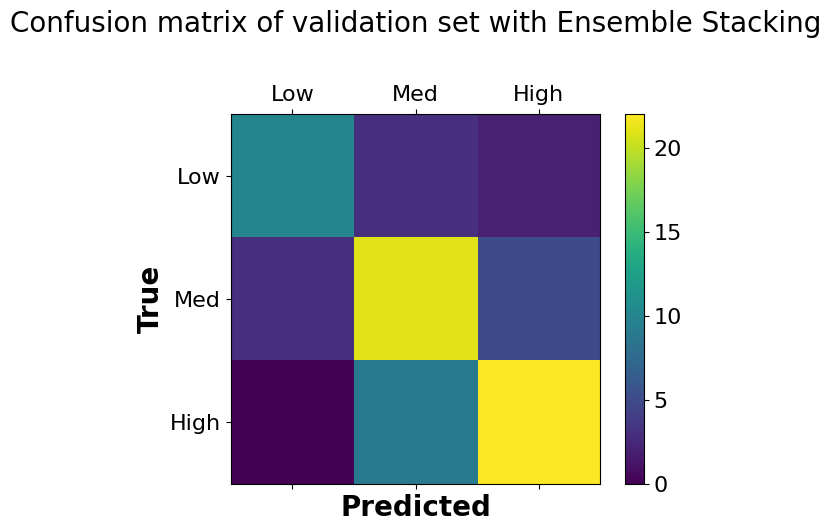

In [77]:
labels = ['Low', 'Med', 'High']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_se, cmap=plt.get_cmap('viridis'))
ax.set_title('Confusion matrix of validation set with Ensemble Stacking', fontsize=20, x=0.5, y=1.2)
cbar=fig.colorbar(cax)
cbar.ax.tick_params(labelsize=16)
ax.set_xticklabels([''] + labels,fontsize=16)
ax.set_yticklabels([''] + labels,fontsize=16)
plt.xlabel('Predicted', fontsize=20, fontweight = 'bold')
plt.ylabel('True', fontsize=20,  fontweight = 'bold')
plt.savefig("CM_Ensemble Stacking.tiff",format ='tiff', dpi=600, bbox_inches='tight',orientation='landscape')
plt.show()

custom error metrics and classification output

In [78]:
#defining the custom predition function

def custom_predict(predicted_prob,threshold):
    
    custom_prediction_array = np.zeros(predicted_prob.shape[0])
    
    for i in range(0,predicted_prob.shape[0]):
        for j in range(0,3):
            if predicted_prob[i,j] >= threshold:
                custom_prediction_array[i] = j+1
            
        if custom_prediction_array[i] == 0:
            if (predicted_prob[i,0]+predicted_prob[i,1]) > 0.7:
                custom_prediction_array[i] = 4
            elif (predicted_prob[i,1]+predicted_prob[i,2]) > 0.7:
                custom_prediction_array[i] = 5
            else:
                custom_prediction_array[i] = 0
        
    return custom_prediction_array 

In [79]:
#function for selection of probability

def choosing_prob(cust_pred_y):
    
    fuzzy_outputs = (sum(cust_pred_y==5) + sum(cust_pred_y==4))/cust_pred_y.shape[0]
    correct = 0
    for i in range(0,y_test.shape[0]):
        if y_test[i] == 1:
            if (cust_pred_y[i] == 1) | (cust_pred_y[i] == 4): correct += 1
        elif y_test[i] == 2:
            if (cust_pred_y[i] == 2) | (cust_pred_y[i] == 4) | (cust_pred_y[i]== 5): correct += 1
        elif y_test[i] == 3:
            if (cust_pred_y[i] == 3) | (cust_pred_y[i] == 5): correct += 1

    accuracy = correct/cust_pred_y.shape[0]
    
    return [accuracy*100, fuzzy_outputs*100]

In [80]:
#iterating over probability choices

probability_choices = [0.5, 0.6, 0.66, 0.7 ,0.8, 0.9]

for item in probability_choices:
    cust_pred_y = custom_predict(y_rf_test_prob,item)
    print (choosing_prob(cust_pred_y))

[74.66666666666667, 8.0]
[84.0, 28.000000000000004]
[88.0, 36.0]
[88.0, 40.0]
[89.33333333333333, 50.66666666666667]
[90.66666666666666, 61.33333333333333]


validation and knowledge aquisition

In [81]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
normele = min_max_scaler.fit_transform(Elements[:,:])

In [82]:
Elementlist=ini_dataset_5.columns.values[0:9]
print(Elementlist)

['C' 'N' 'Ni' 'Al' 'Fe' 'Mo' 'Mn' 'Si' 'Cr']


In [83]:
sato = np.array([[0.07 , 0.0 , 0.0, 1.81 , 79.10, 0.0, 19.10, 0.14, 0],
        [0.05 , 0.0 , 0.0, 4.40 , 76.20, 0.0, 19.40, 0.03, 0],
        [0.07 , 0.0 , 0.0, 0.00 , 68.70, 0.0, 31.30, 0.08, 0],
        [0.07 , 0.0 , 0.0, 2.05 , 68.80, 0.0, 29.14, 0.11, 0],
        [0.06 , 0.0 , 0.0, 3.81 , 67.00, 0.0, 29.18, 0.11, 0],
        [0.07 , 0.0 , 0.0, 7.15 , 64.00, 0.0, 28.80, 0.05, 0]])

In [84]:
def predict_everything(test):
    # Step 1: Standardization (At this point, test_pca has 8 features, which meets the input requirements of the subsequent models)
    norm_test = min_max_scaler.transform(test)
   
   
    predict_test = best_rf.predict(norm_test)
    predict_test_prob = best_rf.predict_proba(norm_test)
    predict_test_custom = custom_predict(predict_test_prob, 0.66)
    
    return [predict_test, predict_test_prob, predict_test_custom]

In [85]:
predict_everything(sato)[2]

array([4., 4., 1., 4., 4., 4.])

Testing your composition

In [86]:
print(Elementlist)

['C' 'N' 'Ni' 'Al' 'Fe' 'Mo' 'Mn' 'Si' 'Cr']


In [87]:
your_composition = np.array([0.033, 0.3514, 13.953, 0, 57.6706, 2.102, 5.033, 0.342, 20.515])

your_composition_twoarray=your_composition.reshape(1,-1)
print(your_composition_twoarray)

[[3.30000e-02 3.51400e-01 1.39530e+01 0.00000e+00 5.76706e+01 2.10200e+00
  5.03300e+00 3.42000e-01 2.05150e+01]]


In [88]:
import warnings
warnings.filterwarnings('ignore')

#your prediction
predicted_classes=predict_everything(your_composition_twoarray)
print(predicted_classes)

[array([3.]), array([[0.16      , 0.00105263, 0.83894737]]), array([3.])]


In [89]:
#RF Prediction
your_compositon_rf=min_max_scaler.transform(your_composition_twoarray)
predicted_classes_rf=best_rf.predict(your_compositon_rf)
predicted_proba_rf=best_rf.predict_proba(your_compositon_rf)
print(predicted_classes_rf)
print(predicted_proba_rf)

[3.]
[[0.16       0.00105263 0.83894737]]


In [90]:
#XGBoost Prdiction
your_compositon_xgb=min_max_scaler.transform(your_composition_twoarray)
predicted_classes_xgb=best_xgb.predict(your_compositon_xgb)+1
predicted_proba_xgb=best_xgb.predict_proba(your_compositon_xgb)
print(predicted_classes_xgb)
print(predicted_proba_xgb)

[3]
[[1.1452585e-02 4.8721480e-04 9.8806018e-01]]


In [91]:
def XGBoost_prediction_intervals(model, X, alpha=0.05):
    # 1.Obtain the score of each tree for each sample (shape: [n_samples, n_classes, n_trees])
    # Note: XGBoost's predict(ntree_limit) can output the scores of the first k trees.
    n_trees = model.n_estimators
    n_classes = model.n_classes_
    tree_probabilities_xgb_in = []
    for tree_idx in range(1, n_trees + 1):
    # Use iteration_range to specify that only the first tree_idx trees are used for prediction
    # predict_proba directly outputs a probability matrix of (number of samples, number of classes)
        tree_probs_xgb_in = model.predict_proba(X,iteration_range=(0, tree_idx))  # Key: Limit the range of trees used
        tree_probabilities_xgb_in.append(tree_probs_xgb_in)
    tree_probabilities_xgb__transposed = np.array(tree_probabilities_xgb_in).transpose(1, 2, 0) 
    
    #Calculate quantile intervals
    lower=np.percentile(tree_probabilities_xgb__transposed,(alpha/2)*100, axis=-1)
    upper=np.percentile(tree_probabilities_xgb__transposed,(1-alpha/2)*100, axis=-1)
    # Final predicted category (the maximum value of the softmax of all tree scores)
    y_pred_proba_xgb=np.mean(tree_probabilities_xgb__transposed,axis=-1)
    y_pred=np.argmax(y_pred_proba_xgb,axis=1)+1
   

    return y_pred, lower, upper

In [92]:
print("Number of actual categories of the model:", best_xgb.n_classes_)

Number of actual categories of the model: 3


In [93]:
# Calculate the 95% prediction interval (class probability interval)
y_pred_new, lower_new, upper_new= XGBoost_prediction_intervals(best_xgb, your_compositon_xgb, alpha=0.05)
# 3. Output result (SFE classification: Low/Medium/High)
print(f"Predicted category of new samples：{y_pred_new[0]}")
print(f"95% interval for Low class probability：[{lower_new[0,0]:.4f}, {upper_new[0,0]:.4f}]")
print(f"95% interval for Medium class probability：[{lower_new[0,1]:.4f}, {upper_new[0,1]:.4f}]")
print(f"95% interval of High class probability：[{lower_new[0,2]:.4f}, {upper_new[0,2]:.4f}]")

Predicted category of new samples：3
95% interval for Low class probability：[0.0115, 0.2130]
95% interval for Medium class probability：[0.0005, 0.2196]
95% interval of High class probability：[0.5679, 0.9880]
